In [5]:
!pip install gymnasium matplotlib numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 13.4 MB/s eta 0:00:00


In [6]:
# from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time

In [7]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):

        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 20

        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3,3]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.final_reward = 0
        self.reward_dict = {(0,0):0,(0,1):0,(0,2):5,(0,3):0
                ,(1,0):0,(1,1):-3,(1,2):0,(1,3):0
                ,(2,0):0,(2,1):0,(2,2):-1,(2,3):0
                ,(3,0):0,(3,1):5,(3,2):0,(3,3):10}


        
    def reset(self, **kwargs):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 20

        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3,3]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.final_reward = 0
        self.reward_dict = {(0,0):0,(0,1):0,(0,2):5,(0,3):0
                ,(1,0):0,(1,1):-3,(1,2):0,(1,3):0
                ,(2,0):0,(2,1):0,(2,2):-1,(2,3):0
                ,(3,0):0,(3,1):5,(3,2):0,(3,3):10}
        observation = self.state.flatten()

        return observation

    def step(self, action):

      if action == 0:
        self.agent_pos[0] += 1
      if action == 1:
        self.agent_pos[0] -= 1
      if action == 2:
        self.agent_pos[1] += 1
      if action == 3:
        self.agent_pos[1] -= 1

      self.agent_pos = np.clip(self.agent_pos, 0, 3)

      self.state = np.zeros((4,4))
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.5
      observation = self.state.flatten()

      reward = int(self.reward_dict[tuple(self.agent_pos)])
      if reward!=0:
        self.reward_dict[tuple(self.agent_pos)] = 0

      self.final_reward += reward
      self.timestep += 1

      terminated = True if (self.timestep >= self.max_timesteps) or (np.all(self.agent_pos==self.goal_pos)) else False
      
      return observation, reward, terminated
      
    def render(self):
      fig, ax = plt.subplots()
      ax.imshow(self.state)
      ax.set_xticks([0.5, 1.5, 2.5, 3.5])
      ax.set_yticks([0.5, 1.5, 2.5, 3.5])
      ax.grid(True)
      for i in range(self.state.shape[0]):
          for j in range(self.state.shape[1]):
              if self.reward_dict[i, j]!=0:
                ax.text(j, i, self.reward_dict[i, j], ha='center', va='center',color='white')
      plt.show()


#  **Part III: DEFINE AN RL ENVIRONMENT using Q-Learning**

In [9]:
class QLearning:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.5, decay_factor=0.01):
        self.action_space = env.action_space
        self.observation_space = env.observation_space
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay_factor = decay_factor
        # Create an empty dictionary to store the Q-values
        self.Q = np.zeros((self.observation_space.n, self.action_space.n))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space.n)
        else:
            return np.argmax(self.Q[int(state), :])

    def update_Q(self, state, action, reward, next_state):
        predict = self.Q[state, action]
        target = reward + self.gamma * np.max(self.Q[next_state, :])
        self.Q[state, action] = self.Q[state, action] + self.alpha * (target - predict)

In [11]:
def run_q_learning(env, agent, gridStates, num_episodes=1000):
    episode_reward = []
    epsilon_over_episodes = []
    
    for episode in range(num_episodes):
        obs = env.reset()
        first_pos = gridStates.get(tuple(env.agent_pos))
        terminated = False
        
        while not terminated:
            first_action = agent.choose_action(first_pos)
            next_obs, reward, terminated = env.step(first_action)
            next_pos = gridStates.get(tuple(env.agent_pos))
            agent.update_Q(first_pos, first_action, reward, next_pos)
            epsilon_over_episodes.append(agent.epsilon)
            
            if agent.epsilon > 0.01:
                agent.epsilon = agent.epsilon * agent.decay_factor
            else:
                agent.epsilon = 0.01
            first_pos = next_pos
            
        if np.all(env.agent_pos == env.goal_pos):
            env.render()
            print(agent.Q)
        
        episode_reward.append(env.final_reward)
    
    return episode_reward, epsilon_over_episodes


In [15]:
def plot_rewards_and_epsilon(episode_reward, epsilon_over_episodes):
    # Plot episode reward
    plt.figure(figsize=(8, 4))
    plt.plot(episode_reward)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Episode - Reward')
    plt.show()

    # Plot epsilon over episodes
    plt.figure(figsize=(8, 4))
    plt.plot(epsilon_over_episodes)
    plt.xlabel('Episodes')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay')
    plt.show()

    # Plot cumulative rewards
    x_values = np.arange(len(episode_reward))
    cumulative_rewards = np.cumsum(episode_reward)
    plt.figure(figsize=(8, 4))
    plt.plot(x_values, cumulative_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Rewards')
    plt.title('Cumulative Rewards over Time')
    plt.show()


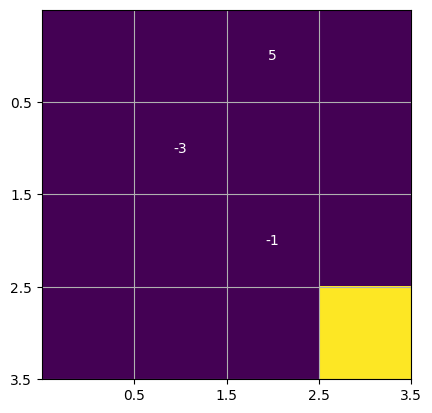

[[ 2.10272284  0.18644474  0.          0.18343356]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.36762911  0.         -0.3         0.        ]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.65356059  0.21565579  0.          0.        ]
 [ 2.24462726  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 1.93476535  1.08409691  3.38046747  1.23444288]
 [ 1.16680658  1.00376349  0.          2.81702817]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          0.        ]]


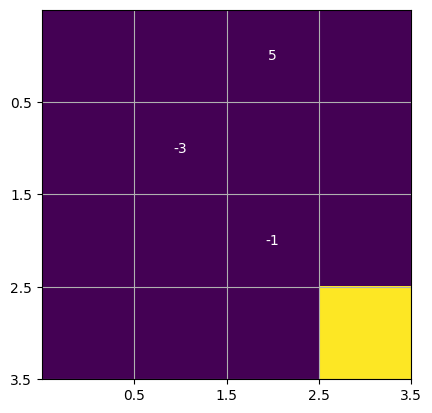

[[ 2.11118317  0.18644474  0.          0.18343356]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.38113488  0.         -0.3         0.        ]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.713899    0.21565579  0.          0.        ]
 [ 2.24462726  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 1.93476535  1.08409691  3.20117753  1.23444288]
 [ 1.16680658  1.00376349  0.09        3.00002732]
 [ 0.          0.          1.9         0.        ]
 [ 0.          0.          0.          0.        ]]


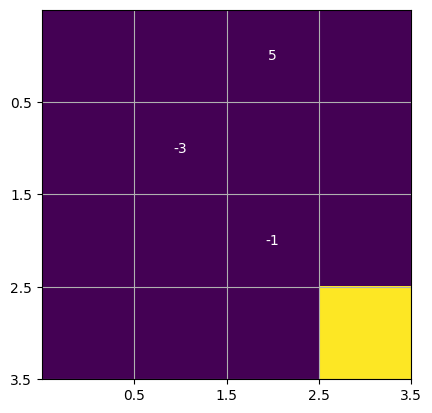

[[ 2.07800463  0.18644474  0.          0.18343356]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.31150176  0.19524425 -0.3         0.        ]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.57048069  0.21565579  0.          0.43922433]
 [ 2.33847231  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.01170683  1.2050664   2.92923774  1.51663672]
 [ 1.3192103   1.28941145  0.252       2.76957024]
 [ 0.          0.          2.71        0.        ]
 [ 0.          0.          0.          0.        ]]


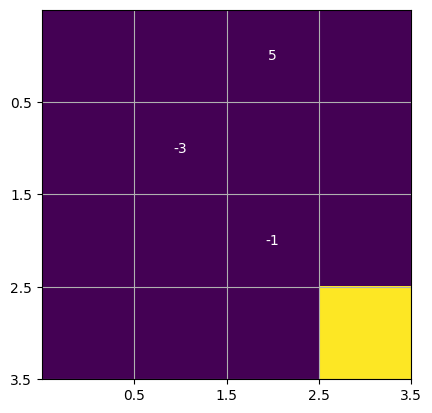

[[ 2.09449842  0.18644474  0.          0.18343356]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.32128272  0.19524425 -0.3         0.        ]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.56268274  0.21565579  0.          0.43922433]
 [ 2.35635866  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.09089985  1.31717747  3.13631936  1.51663672]
 [ 1.4405736   1.37093281  0.4707      2.76267688]
 [ 0.          0.          3.439       0.        ]
 [ 0.          0.          0.          0.        ]]


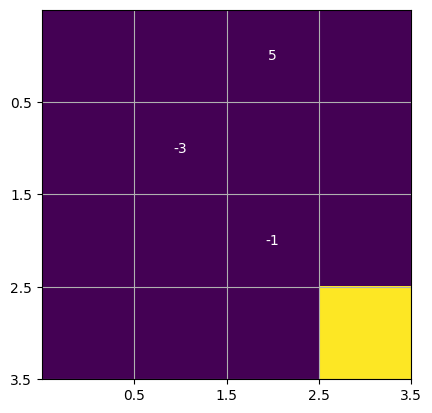

[[ 2.13253111  0.18644474  0.          0.18343356]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.37243593  0.19524425 -0.3         0.        ]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.61484279  0.21565579  0.          0.43922433]
 [ 2.37474886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.09089985  1.60186205  2.94561172  1.62976041]
 [ 1.5520039   1.44591181  0.73314     2.78609421]
 [ 0.          0.          4.0951      0.        ]
 [ 0.          0.          0.          0.        ]]


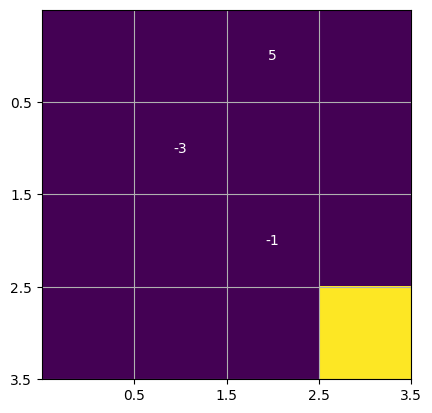

[[ 2.10065704  0.18644474  0.          0.18343356]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.32526479  0.19524425 -0.3         0.        ]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.57653204  0.21565579  0.          0.62727892]
 [ 2.38813081  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.09089985  1.60186205  3.03838072  1.62976041]
 [ 1.81196081  1.51504803  1.028385    2.79253099]
 [ 0.          0.          4.68559     0.        ]
 [ 0.          0.          0.          0.        ]]


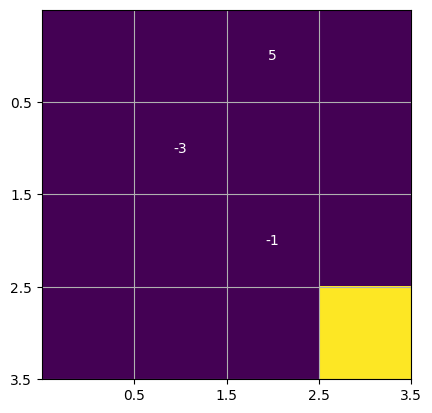

[[ 2.09788897  0.18644474  0.          0.18343356]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.33381933  0.19524425 -0.3         0.        ]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.60975492  0.21565579  0.          0.62727892]
 [ 2.38813081  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.09089985  1.60186205  3.14102865  1.62976041]
 [ 1.81196081  1.51504803  1.3472496   2.83867259]
 [ 0.          0.          5.217031    0.        ]
 [ 0.          0.          0.          0.        ]]


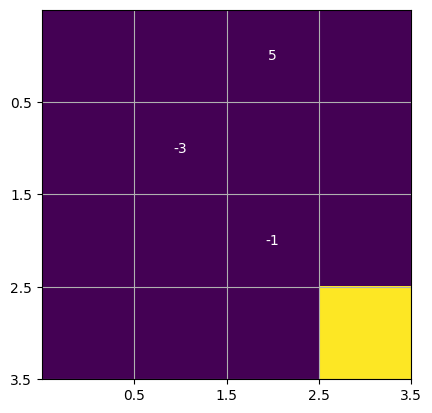

[[ 2.12274844  0.18644474  0.          0.18343356]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.3569598   0.19524425 -0.3         0.        ]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.60966079  0.21565579  0.          0.62727892]
 [ 2.40343418  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.09089985  1.67567337  3.11342466  1.75129939]
 [ 1.94431302  1.578475    1.68205743  2.81073701]
 [ 0.          0.          5.6953279   0.        ]
 [ 0.          0.          0.          0.        ]]


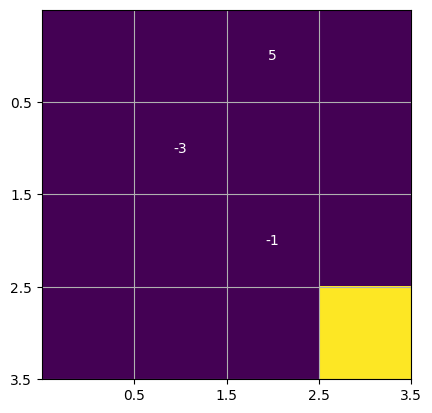

[[ 2.09089314  0.18644474  0.          0.18343356]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.31252214  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.55735661  0.21565579  0.          0.62727892]
 [ 2.40343418  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.80094804  3.01384063  1.92512349]
 [ 2.00224791  1.578475    2.0264312   2.76829244]
 [ 0.          0.          6.12579511  0.        ]
 [ 0.          0.          0.          0.        ]]


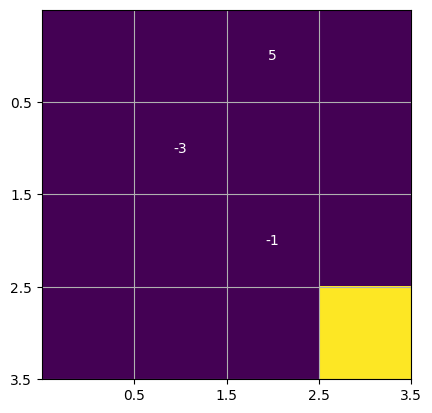

[[ 2.08942645  0.18644474  0.          0.18343356]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.32765708  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.58996568  0.21565579  0.          0.62727892]
 [ 2.40343418  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.85412853  3.32196521  1.92512349]
 [ 2.00224791  1.578475    2.37510964  2.75755289]
 [ 0.          0.          6.5132156   0.        ]
 [ 0.          0.          0.          0.        ]]


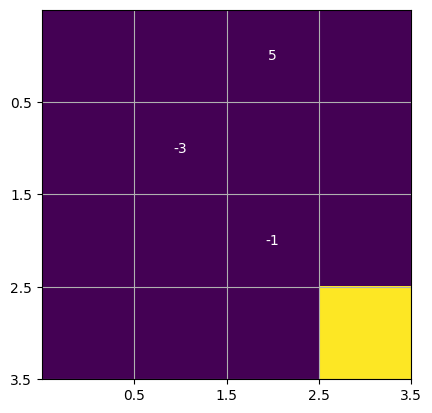

[[ 2.09459924  0.18644474  0.          0.18343356]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.33860711  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.59424861  0.21565579  0.21630908  0.62727892]
 [ 2.9250526   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.85412853  3.12598746  1.92512349]
 [ 2.00224791  1.578475    2.72378808  2.75248819]
 [ 0.          0.          6.86189404  0.        ]
 [ 0.          0.          0.          0.        ]]


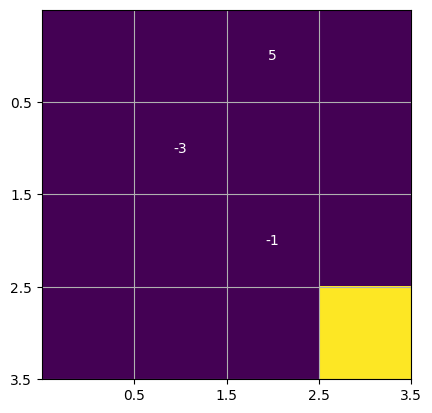

[[ 2.10224192  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.33070775  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.59098512  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  3.26507717  2.0101209 ]
 [ 2.05855114  1.7746853   3.06897973  2.80265913]
 [ 0.          0.          7.17570464  0.        ]
 [ 0.          0.          0.          0.        ]]


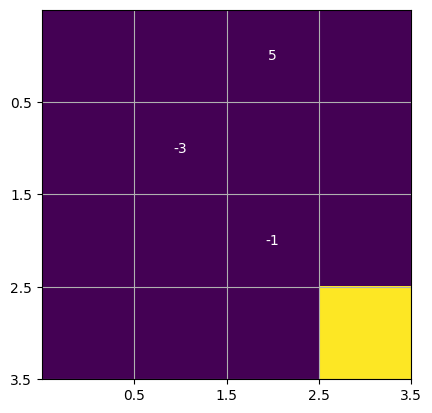

[[ 2.10178142  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.33082563  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.62574355  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  3.71477763  2.0101209 ]
 [ 2.05855114  1.7746853   3.40789518  2.80265913]
 [ 0.          0.          7.45813417  0.        ]
 [ 0.          0.          0.          0.        ]]


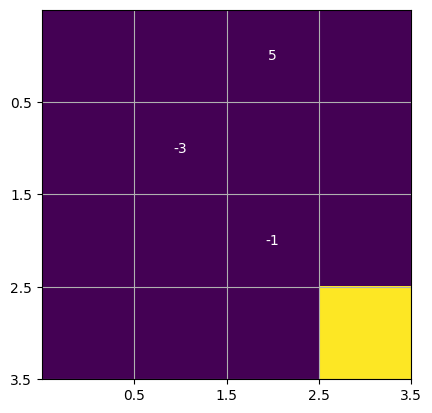

[[ 2.10137759  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.33405999  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.69749918  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  4.15001043  2.0101209 ]
 [ 2.05855114  1.7746853   3.73833774  2.80265913]
 [ 0.          0.          7.71232075  0.        ]
 [ 0.          0.          0.          0.        ]]


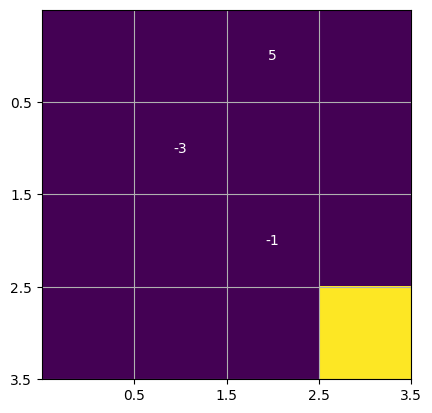

[[ 2.10130523  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.34342892  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.8012502   0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  4.57145979  2.0101209 ]
 [ 2.05855114  1.7746853   4.05861283  2.80265913]
 [ 0.          0.          7.94108868  0.        ]
 [ 0.          0.          0.          0.        ]]


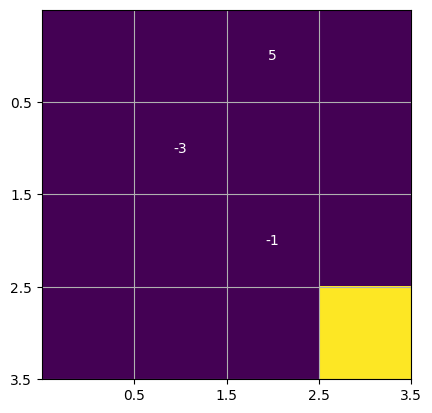

[[ 2.10208331  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.36119854  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.93255656  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  4.97958896  2.0101209 ]
 [ 2.05855114  1.7746853   4.36744953  2.80265913]
 [ 0.          0.          8.14697981  0.        ]
 [ 0.          0.          0.          0.        ]]


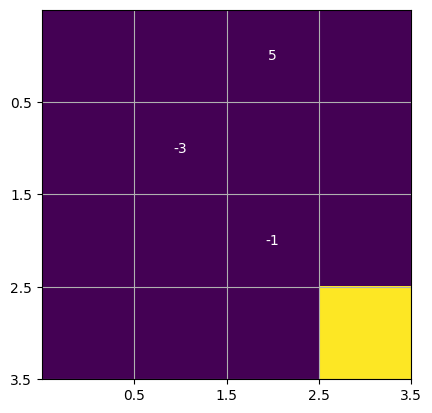

[[ 2.10438285  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.38900878  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.08746391  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  5.37470052  2.0101209 ]
 [ 2.05855114  1.7746853   4.66393276  2.80265913]
 [ 0.          0.          8.33228183  0.        ]
 [ 0.          0.          0.          0.        ]]


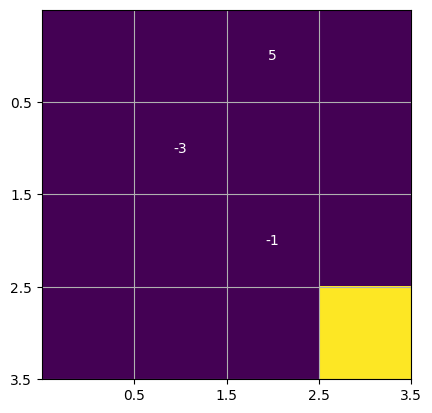

[[ 2.10895535  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.42797965  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.26244057  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  5.75698442  2.0101209 ]
 [ 2.05855114  1.7746853   4.94744485  2.80265913]
 [ 0.          0.          8.49905365  0.        ]
 [ 0.          0.          0.          0.        ]]


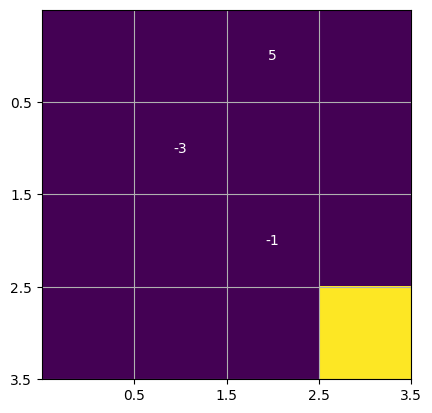

[[ 2.11657799  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.47880134  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.45432511  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  6.12655601  2.0101209 ]
 [ 2.05855114  1.7746853   5.21761519  2.80265913]
 [ 0.          0.          8.64914828  0.        ]
 [ 0.          0.          0.          0.        ]]


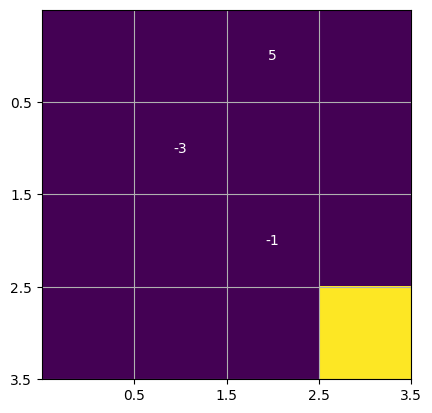

[[ 2.12801231  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.54181047  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.66028264  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  6.48348578  2.0101209 ]
 [ 2.05855114  1.7746853   5.47427702  2.80265913]
 [ 0.          0.          8.78423345  0.        ]
 [ 0.          0.          0.          0.        ]]


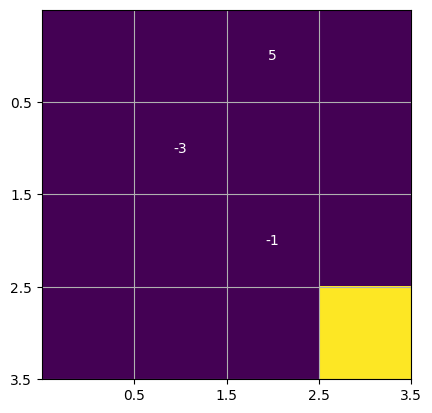

[[ 2.14397402  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.61705486  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.8777681   0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  6.82782213  2.0101209 ]
 [ 2.05855114  1.7746853   5.71743033  2.80265913]
 [ 0.          0.          8.90581011  0.        ]
 [ 0.          0.          0.          0.        ]]


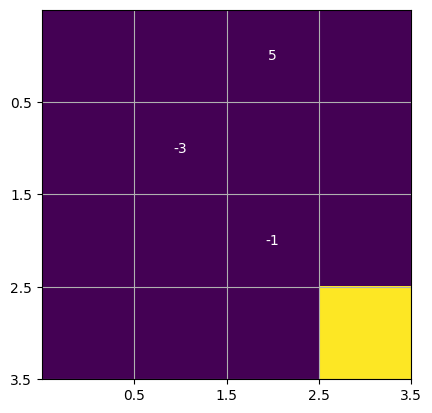

[[ 2.16511155  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.7043485   0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 4.10449528  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  7.15960865  2.0101209 ]
 [ 2.05855114  1.7746853   5.9472102   2.80265913]
 [ 0.          0.          9.0152291   0.        ]
 [ 0.          0.          0.          0.        ]]


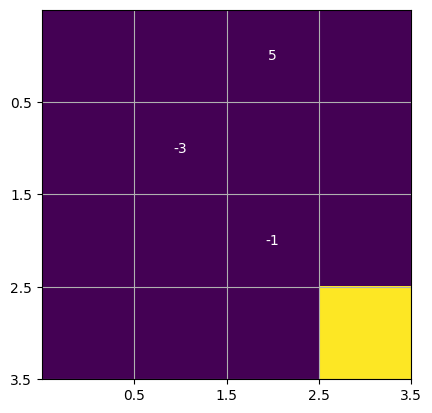

[[ 2.19199176  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.80331823  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 4.33841053  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  7.4788967   2.0101209 ]
 [ 2.05855114  1.7746853   6.1638598   2.80265913]
 [ 0.          0.          9.11370619  0.        ]
 [ 0.          0.          0.          0.        ]]


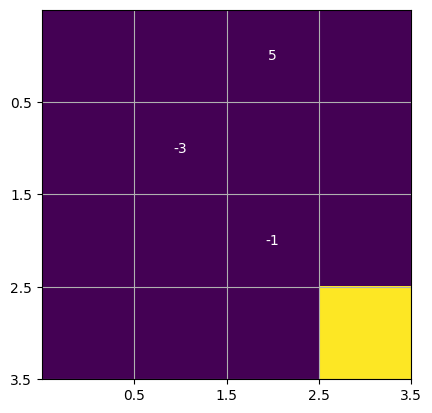

[[ 2.22509123  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.91344335  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 4.57767018  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  7.78575441  2.0101209 ]
 [ 2.05855114  1.7746853   6.36770738  2.80265913]
 [ 0.          0.          9.20233557  0.        ]
 [ 0.          0.          0.          0.        ]]


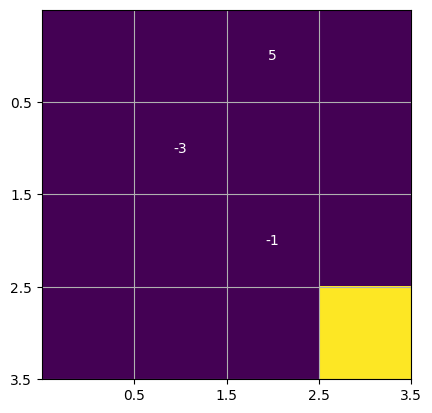

[[ 2.26479201  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.03408933  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 4.82062106  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  8.08027264  2.0101209 ]
 [ 2.05855114  1.7746853   6.55914684  2.80265913]
 [ 0.          0.          9.28210201  0.        ]
 [ 0.          0.          0.          0.        ]]


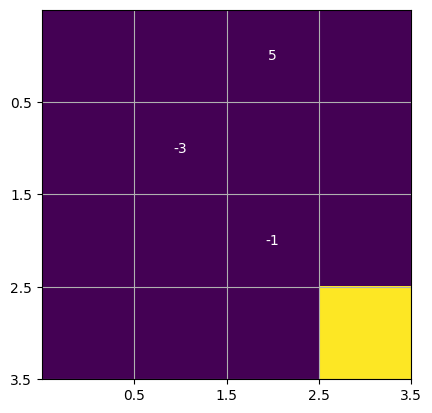

[[ 2.31138085  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.16453629  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 5.06578349  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  8.36256859  2.0101209 ]
 [ 2.05855114  1.7746853   6.73862134  2.80265913]
 [ 0.          0.          9.35389181  0.        ]
 [ 0.          0.          0.          0.        ]]


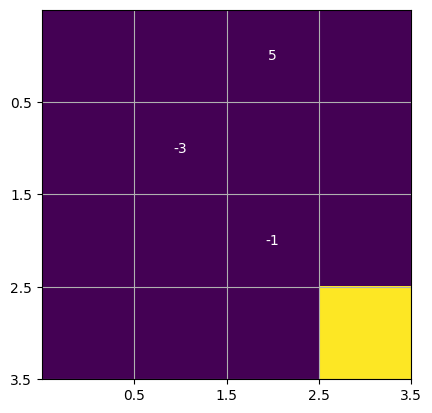

[[ 2.36505103  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.30400318  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 5.31183631  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  8.63278765  2.0101209 ]
 [ 2.05855114  1.7746853   6.90660947  2.80265913]
 [ 0.          0.          9.41850263  0.        ]
 [ 0.          0.          0.          0.        ]]


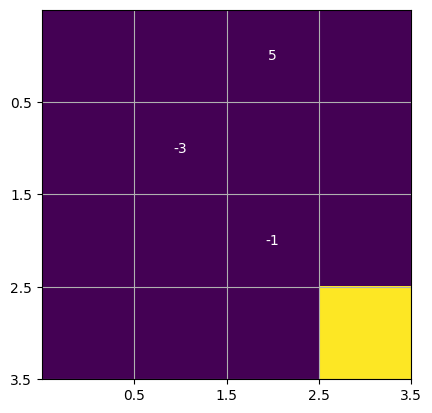

[[ 2.42590621  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.45166813  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 5.55760357  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  8.89110374  2.0101209 ]
 [ 2.05855114  1.7746853   7.06361376  2.80265913]
 [ 0.          0.          9.47665237  0.        ]
 [ 0.          0.          0.          0.        ]]


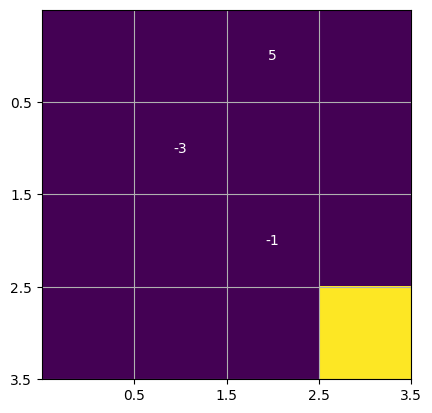

[[ 2.49396572  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.60668564  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 5.80204255  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  9.1377186   2.0101209 ]
 [ 2.05855114  1.7746853   7.2101511   2.80265913]
 [ 0.          0.          9.52898713  0.        ]
 [ 0.          0.          0.          0.        ]]


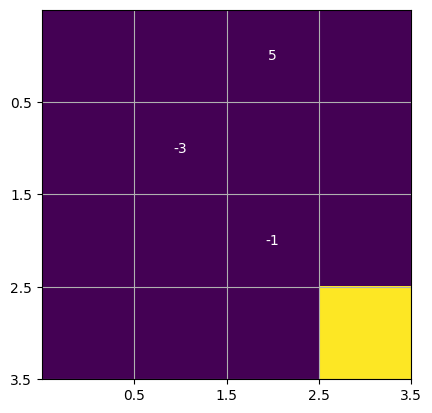

[[ 2.56917086  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.7682009   0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 6.04423297  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  9.37286034  2.0101209 ]
 [ 2.05855114  1.7746853   7.34674483  2.80265913]
 [ 0.          0.          9.57608842  0.        ]
 [ 0.          0.          0.          0.        ]]


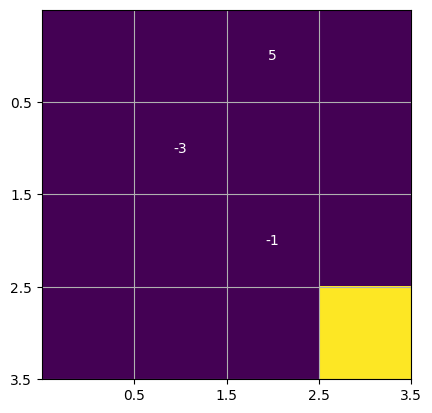

[[ 2.65139185  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.93536178  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 6.2833671   0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  9.59678134  2.0101209 ]
 [ 2.05855114  1.7746853   7.4739183   2.80265913]
 [ 0.          0.          9.61847958  0.        ]
 [ 0.          0.          0.          0.        ]]


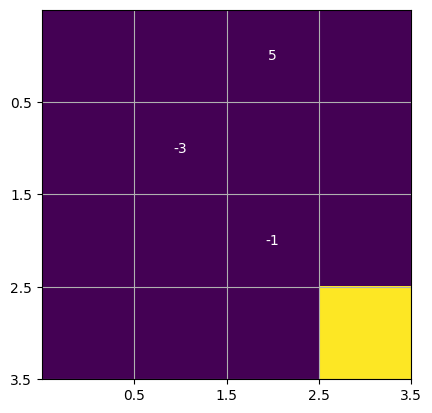

[[ 2.74043523  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 4.10732864  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 6.51874071  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594  9.80975585  2.0101209 ]
 [ 2.05855114  1.7746853   7.59218963  2.80265913]
 [ 0.          0.          9.65663162  0.        ]
 [ 0.          0.          0.          0.        ]]


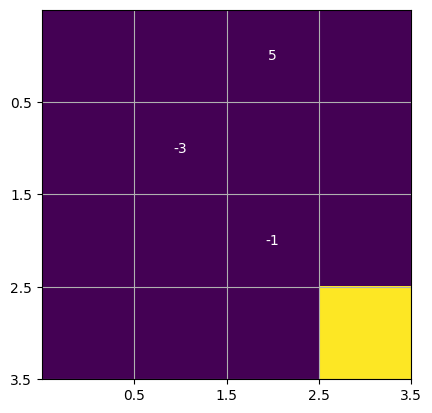

[[ 2.83605128  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 4.28328244  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 6.74974467  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 10.01207734  2.0101209 ]
 [ 2.05855114  1.7746853   7.70206752  2.80265913]
 [ 0.          0.          9.69096846  0.        ]
 [ 0.          0.          0.          0.        ]]


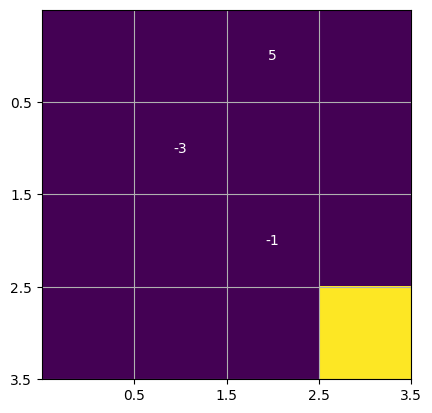

[[ 2.93794157  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 4.46243122  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 6.97585716  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 10.20405568  2.0101209 ]
 [ 2.05855114  1.7746853   7.80404793  2.80265913]
 [ 0.          0.          9.72187161  0.        ]
 [ 0.          0.          0.          0.        ]]


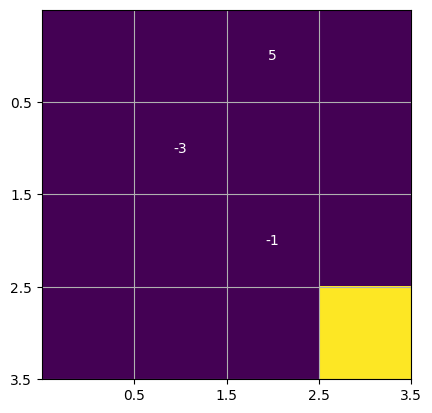

[[ 3.04576623  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 4.64401524  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 7.19663646  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 10.38601442  2.0101209 ]
 [ 2.05855114  1.7746853   7.89861158  2.80265913]
 [ 0.          0.          9.74968445  0.        ]
 [ 0.          0.          0.          0.        ]]


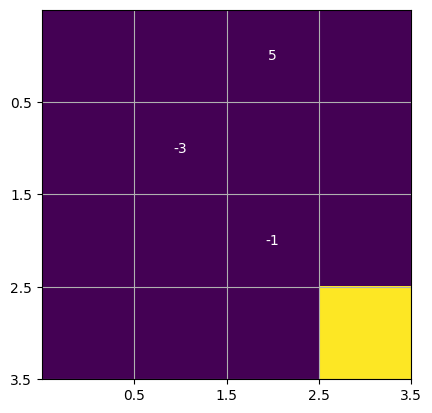

[[ 3.15915098  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 4.827311    0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 7.41171411  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 10.55828802  2.0101209 ]
 [ 2.05855114  1.7746853   7.98622202  2.80265913]
 [ 0.          0.          9.774716    0.        ]
 [ 0.          0.          0.          0.        ]]


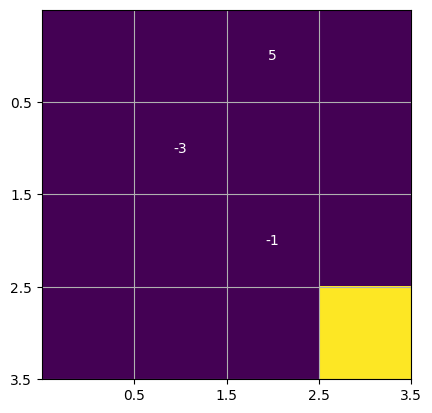

[[ 3.27769387  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 5.01163417  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 7.62078862  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 10.7212192   2.0101209 ]
 [ 2.05855114  1.7746853   8.06732426  2.80265913]
 [ 0.          0.          9.7972444   0.        ]
 [ 0.          0.          0.          0.        ]]


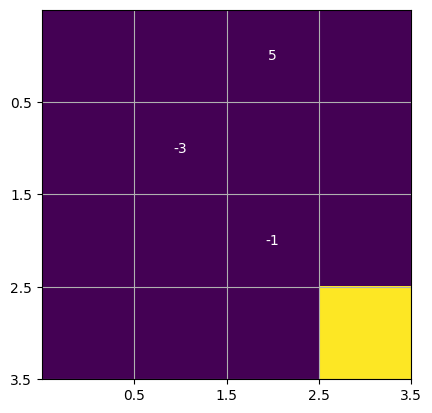

[[ 3.40097156  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 5.19634173  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 7.82361949  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 10.87515647  2.0101209 ]
 [ 2.05855114  1.7746853   8.14234383  2.80265913]
 [ 0.          0.          9.81751996  0.        ]
 [ 0.          0.          0.          0.        ]]


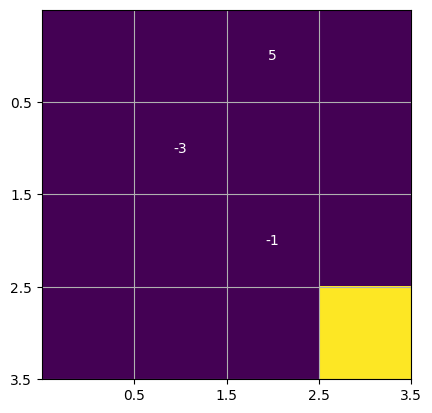

[[ 3.52854516  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 5.38083331  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.02002162  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 11.02045176  2.0101209 ]
 [ 2.05855114  1.7746853   8.21168624  2.80265913]
 [ 0.          0.          9.83576797  0.        ]
 [ 0.          0.          0.          0.        ]]


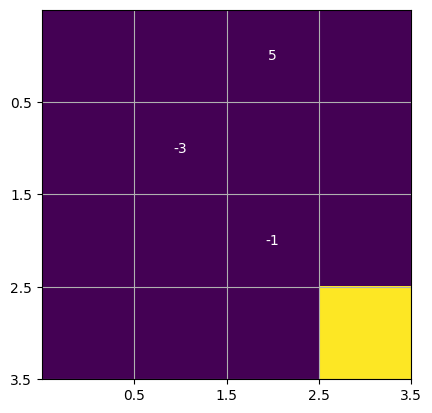

[[ 3.65996564  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 5.56455192  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.20986012  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 11.15745835  2.0101209 ]
 [ 2.05855114  1.7746853   8.27573674  2.80265913]
 [ 0.          0.          9.85219117  0.        ]
 [ 0.          0.          0.          0.        ]]


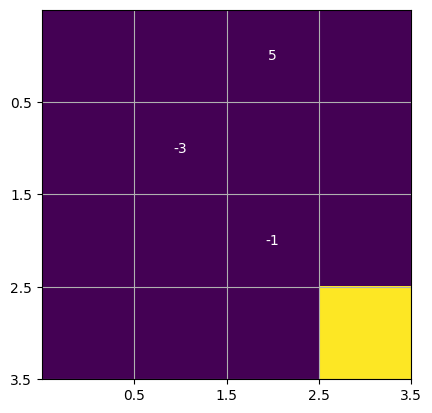

[[ 3.79477875  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 5.74698414  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.39304536  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 11.28652882  2.0101209 ]
 [ 2.05855114  1.7746853   8.33486027  2.80265913]
 [ 0.          0.          9.86697205  0.        ]
 [ 0.          0.          0.          0.        ]]


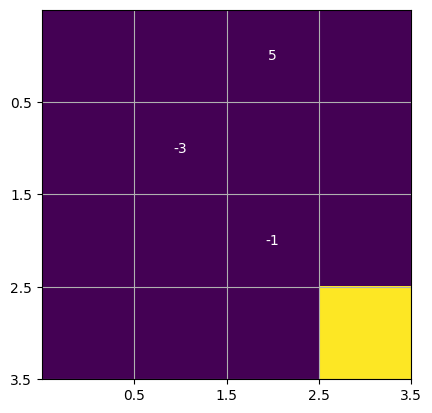

[[ 3.93252945  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 5.92765981  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.56952842  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 11.40801336  2.0101209 ]
 [ 2.05855114  1.7746853   8.38940173  2.80265913]
 [ 0.          0.          9.88027485  0.        ]
 [ 0.          0.          0.          0.        ]]


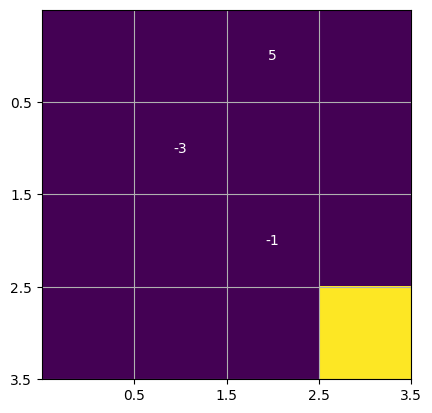

[[ 4.07276588  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 6.10615139  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.73929678  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 11.52225818  2.0101209 ]
 [ 2.05855114  1.7746853   8.43968629  2.80265913]
 [ 0.          0.          9.89224736  0.        ]
 [ 0.          0.          0.          0.        ]]


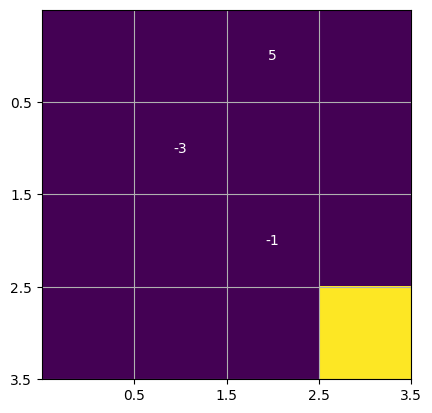

[[ 4.21504292  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 6.28207296  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.90237033  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 11.62960413  2.0101209 ]
 [ 2.05855114  1.7746853   8.48601992  2.80265913]
 [ 0.          0.          9.90302263  0.        ]
 [ 0.          0.          0.          0.        ]]


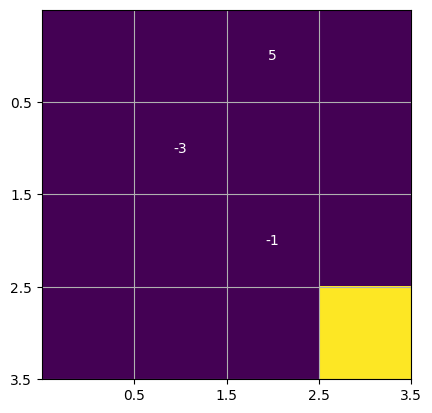

[[ 4.35892519  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 6.45507899  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.05879767  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 11.73038551  2.0101209 ]
 [ 2.05855114  1.7746853   8.52868997  2.80265913]
 [ 0.          0.          9.91272036  0.        ]
 [ 0.          0.          0.          0.        ]]


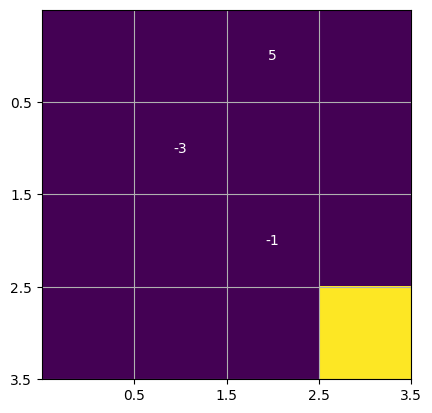

[[ 4.50398978  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 6.62486288  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.2086526   0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 11.82492906  2.0101209 ]
 [ 2.05855114  1.7746853   8.5679658   2.80265913]
 [ 0.          0.          9.92144833  0.        ]
 [ 0.          0.          0.          0.        ]]


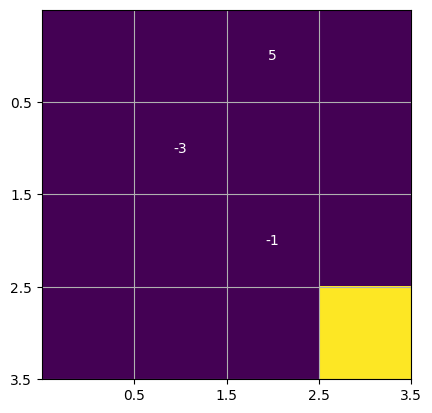

[[ 4.64982846  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 6.79115533  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.35203096  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 11.91355307  2.0101209 ]
 [ 2.05855114  1.7746853   8.60409957  2.80265913]
 [ 0.          0.          9.9293035   0.        ]
 [ 0.          0.          0.          0.        ]]


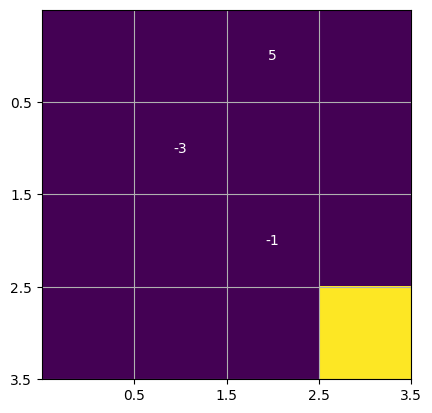

[[ 4.7960496   0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 6.95372258  0.19524425 -0.3         0.21303079]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.48904764  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 11.99656673  2.0101209 ]
 [ 2.05855114  1.7746853   8.63732693  2.80265913]
 [ 0.          0.          9.93637315  0.        ]
 [ 0.          0.          0.          0.        ]]


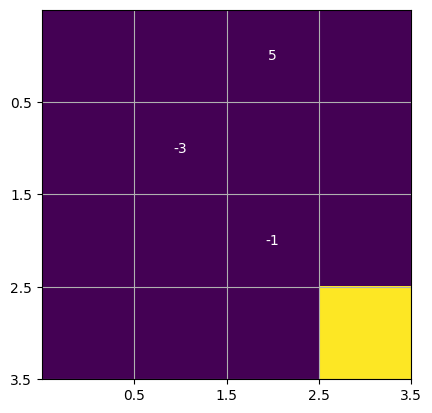

[[ 4.94227967  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 7.11236461  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.61983388  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.07426948  2.0101209 ]
 [ 2.05855114  1.7746853   8.66786782  2.80265913]
 [ 0.          0.          9.94273583  0.        ]
 [ 0.          0.          0.          0.        ]]


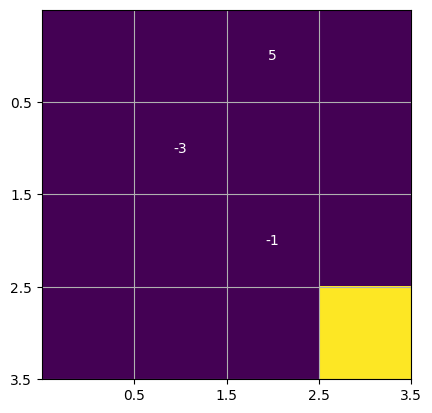

[[ 5.08816452  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 7.2669132   0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.74453474  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.14695063  2.0101209 ]
 [ 2.05855114  1.7746853   8.69592726  2.80265913]
 [ 0.          0.          9.94846225  0.        ]
 [ 0.          0.          0.          0.        ]]


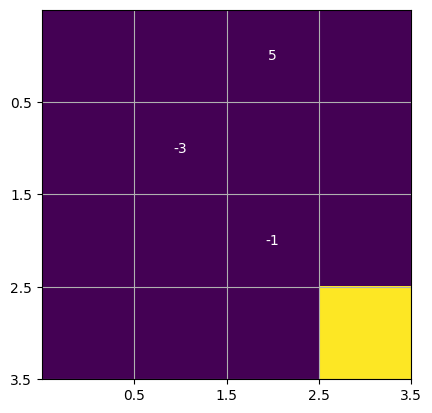

[[ 5.23337025  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 7.41723001  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.86330683  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.21488902  2.0101209 ]
 [ 2.05855114  1.7746853   8.72169614  2.80265913]
 [ 0.          0.          9.95361602  0.        ]
 [ 0.          0.          0.          0.        ]]


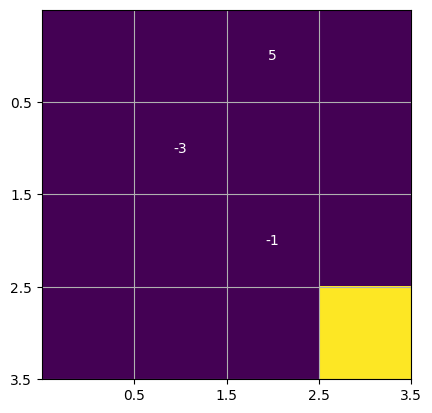

[[ 5.37758393  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 7.56320462  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.97631616  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.27835277  2.0101209 ]
 [ 2.05855114  1.7746853   8.74535197  2.80265913]
 [ 0.          0.          9.95825442  0.        ]
 [ 0.          0.          0.          0.        ]]


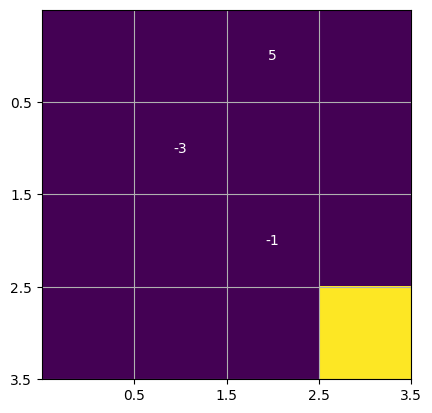

[[ 5.52051395  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 7.70475261  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.08373629  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.33759917  2.0101209 ]
 [ 2.05855114  1.7746853   8.76705967  2.80265913]
 [ 0.          0.          9.96242898  0.        ]
 [ 0.          0.          0.          0.        ]]


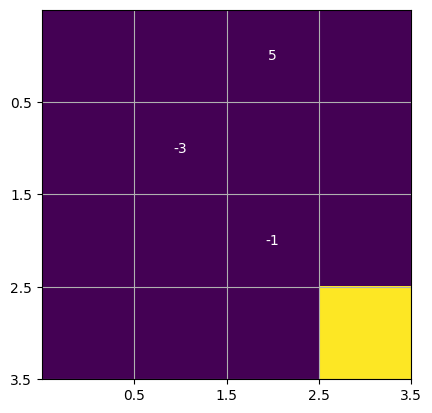

[[ 5.66189029  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 7.84181362  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.18574659  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.39287463  2.0101209 ]
 [ 2.05855114  1.7746853   8.78697231  2.80265913]
 [ 0.          0.          9.96618608  0.        ]
 [ 0.          0.          0.          0.        ]]


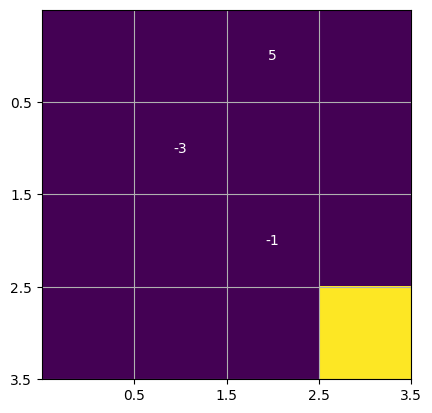

[[ 5.80146449  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 7.97434945  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.28253064  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.44441467  2.0101209 ]
 [ 2.05855114  1.7746853   8.80523183  2.80265913]
 [ 0.          0.          9.96956747  0.        ]
 [ 0.          0.          0.          0.        ]]


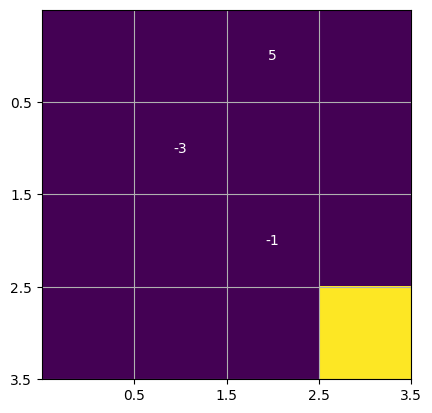

[[ 5.93900949  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.10234226  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.3742749   0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.49244407  2.0101209 ]
 [ 2.05855114  1.7746853   8.82196972  2.80265913]
 [ 0.          0.          9.97261073  0.        ]
 [ 0.          0.          0.          0.        ]]


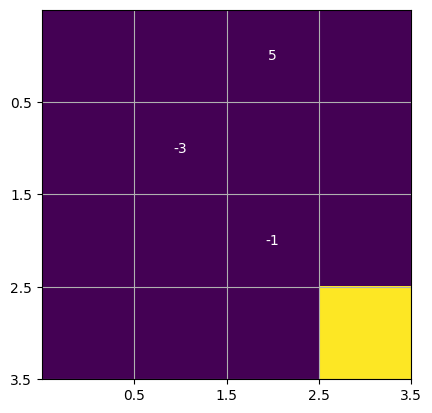

[[ 6.07431934  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.22579278  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.46116738  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.53717694  2.0101209 ]
 [ 2.05855114  1.7746853   8.83730771  2.80265913]
 [ 0.          0.          9.97534965  0.        ]
 [ 0.          0.          0.          0.        ]]


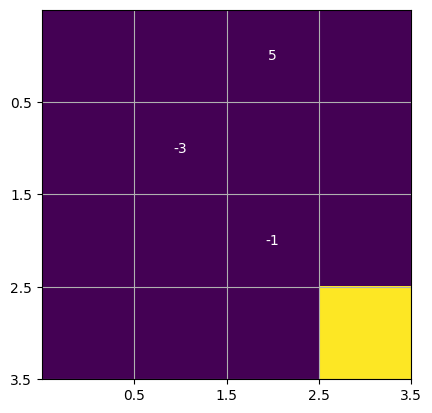

[[ 6.20720876  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.34471856  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.54339656  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.57881694  2.0101209 ]
 [ 2.05855114  1.7746853   8.85135841  2.80265913]
 [ 0.          0.          9.97781469  0.        ]
 [ 0.          0.          0.          0.        ]]


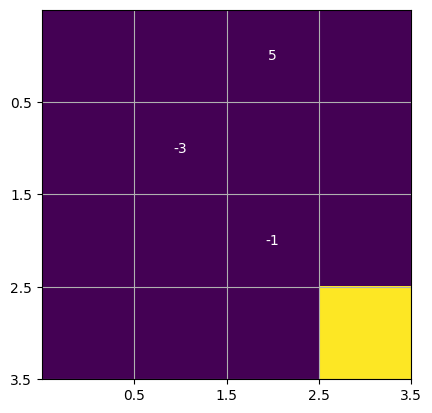

[[ 6.33751255  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.4591524   0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.62115043  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.6175575   2.0101209 ]
 [ 2.05855114  1.7746853   8.86422589  2.80265913]
 [ 0.          0.          9.98003322  0.        ]
 [ 0.          0.          0.          0.        ]]


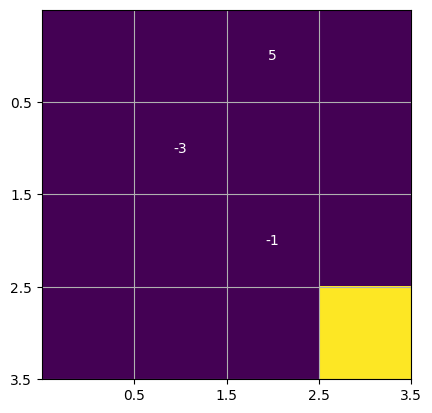

[[ 6.46508501  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.5691407   0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.69461556  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.65358208  2.0101209 ]
 [ 2.05855114  1.7746853   8.87600629  2.80265913]
 [ 0.          0.          9.9820299   0.        ]
 [ 0.          0.          0.          0.        ]]


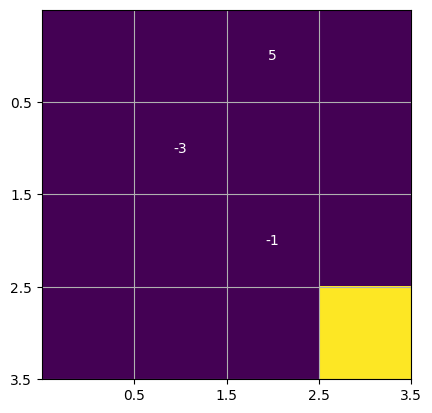

[[ 6.58979918  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.67474203  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.76397639  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.68706444  2.0101209 ]
 [ 2.05855114  1.7746853   8.88678835  2.80265913]
 [ 0.          0.          9.98382691  0.        ]
 [ 0.          0.          0.          0.        ]]


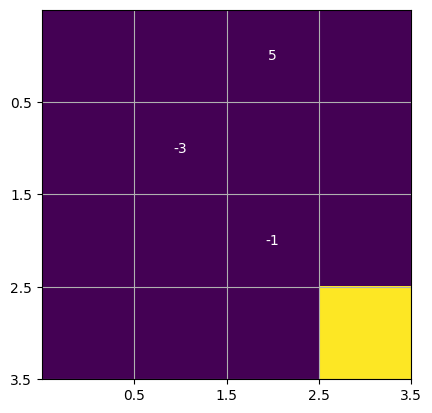

[[ 6.71154604  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.7760257   0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.82941455  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.71816895  2.0101209 ]
 [ 2.05855114  1.7746853   8.89665394  2.80265913]
 [ 0.          0.          9.98544422  0.        ]
 [ 0.          0.          0.          0.        ]]


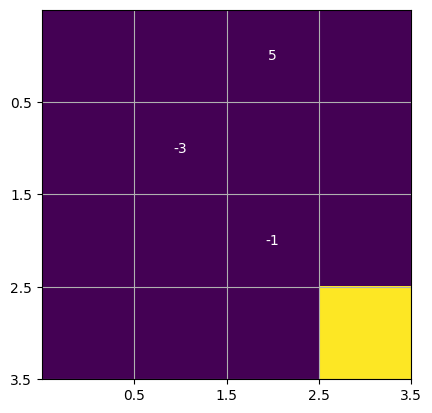

[[ 6.83023375  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.87307044  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.8911083   0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.74705091  2.0101209 ]
 [ 2.05855114  1.7746853   8.90567852  2.80265913]
 [ 0.          0.          9.98689979  0.        ]
 [ 0.          0.          0.          0.        ]]


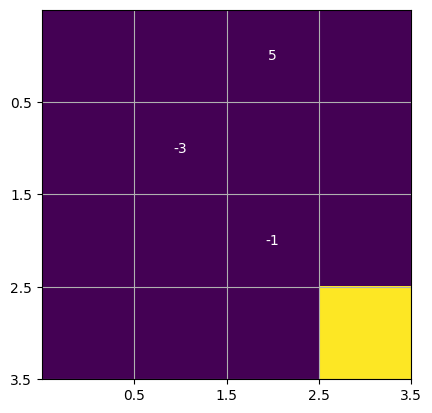

[[ 6.94578671  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.96596314  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.94923205  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.77385688  2.0101209 ]
 [ 2.05855114  1.7746853   8.91393165  2.80265913]
 [ 0.          0.          9.98820982  0.        ]
 [ 0.          0.          0.          0.        ]]


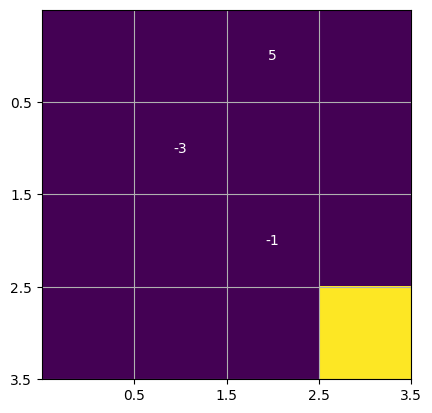

[[ 7.05814473  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.05479771  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.00395597  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.79872504  2.0101209 ]
 [ 2.05855114  1.7746853   8.92147737  2.80265913]
 [ 0.          0.          9.98938883  0.        ]
 [ 0.          0.          0.          0.        ]]


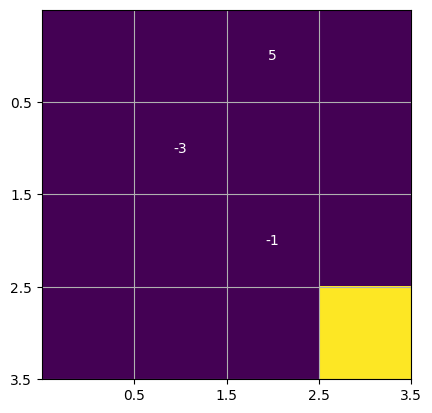

[[ 7.16726205  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.13967398  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.05544563  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.8217855   2.0101209 ]
 [ 2.05855114  1.7746853   8.92837463  2.80265913]
 [ 0.          0.          9.99044995  0.        ]
 [ 0.          0.          0.          0.        ]]


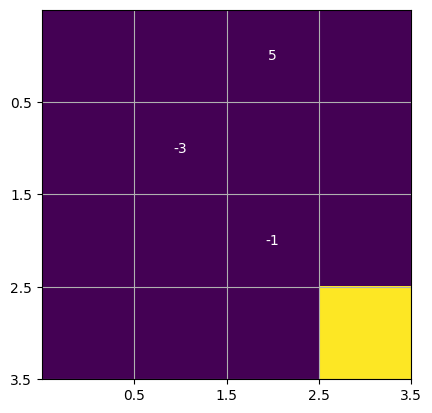

[[ 7.2731065   0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.22069669  0.19524425 -0.3         0.81756274]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.10386176  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.84316067  2.0101209 ]
 [ 2.05855114  1.7746853   8.93467766  2.80265913]
 [ 0.          0.          9.99140496  0.        ]
 [ 0.          0.          0.          0.        ]]


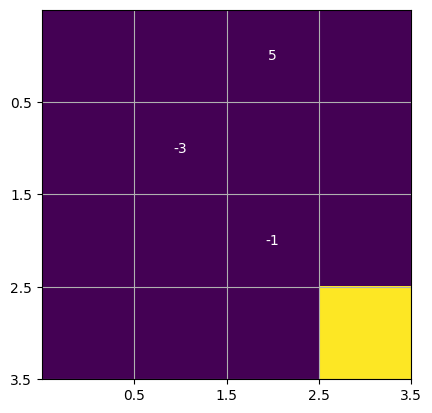

[[ 7.37565855  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.29797458  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.14936004  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.86296559  2.0101209 ]
 [ 2.05855114  1.7746853   8.94043634  2.80265913]
 [ 0.          0.          9.99226446  0.        ]
 [ 0.          0.          0.          0.        ]]


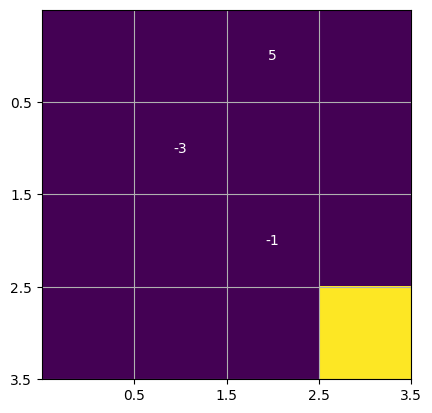

[[ 7.47491041  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.37161952  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.19209094  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.8813083   2.0101209 ]
 [ 2.05855114  1.7746853   8.94569651  2.80265913]
 [ 0.          0.          9.99303801  0.        ]
 [ 0.          0.          0.          0.        ]]


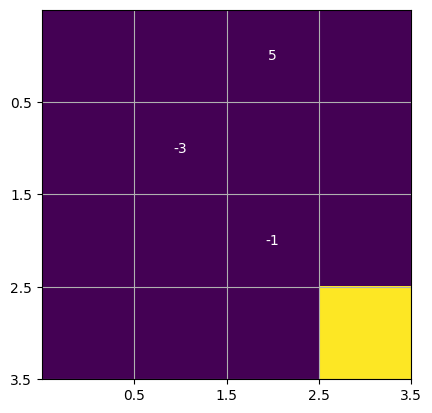

[[ 7.57086513  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.44174576  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.23219959  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.89829016  2.0101209 ]
 [ 2.05855114  1.7746853   8.95050028  2.80265913]
 [ 0.          0.          9.99373421  0.        ]
 [ 0.          0.          0.          0.        ]]


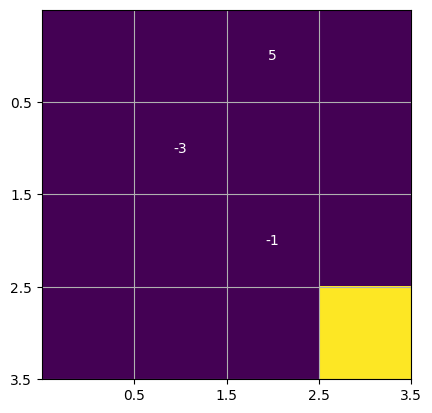

[[ 7.66353573  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.50846914  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.26982575  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.91400617  2.0101209 ]
 [ 2.05855114  1.7746853   8.95488633  2.80265913]
 [ 0.          0.          9.99436079  0.        ]
 [ 0.          0.          0.          0.        ]]


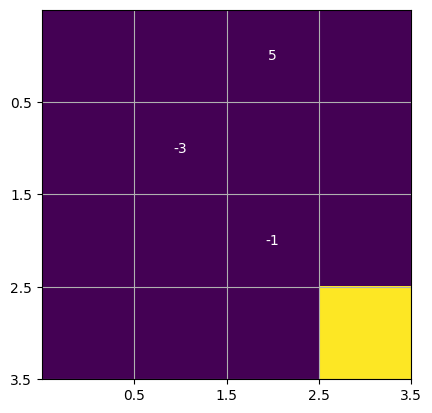

[[ 7.75294438  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.57190655  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.30510373  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.92854532  2.0101209 ]
 [ 2.05855114  1.7746853   8.95889017  2.80265913]
 [ 0.          0.          9.99492471  0.        ]
 [ 0.          0.          0.          0.        ]]


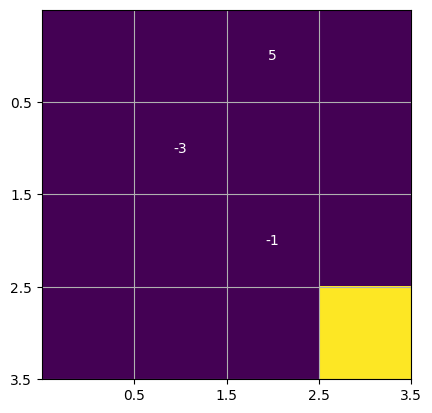

[[ 7.83912153  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.63217523  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.33816244  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.9419909   2.0101209 ]
 [ 2.05855114  1.7746853   8.96254438  2.80265913]
 [ 0.          0.          9.99543224  0.        ]
 [ 0.          0.          0.          0.        ]]


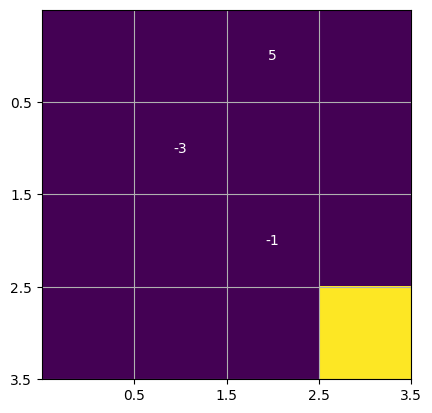

[[ 7.92210515  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.68939232  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.36912537  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.95442081  2.0101209 ]
 [ 2.05855114  1.7746853   8.96587884  2.80265913]
 [ 0.          0.          9.99588902  0.        ]
 [ 0.          0.          0.          0.        ]]


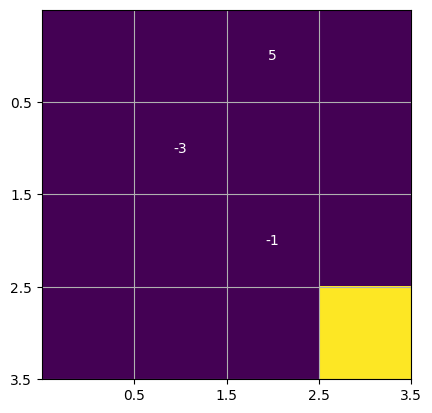

[[ 8.00193994  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.74367438  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.39811071  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.96590782  2.0101209 ]
 [ 2.05855114  1.7746853   8.96892097  2.80265913]
 [ 0.          0.          9.99630012  0.        ]
 [ 0.          0.          0.          0.        ]]


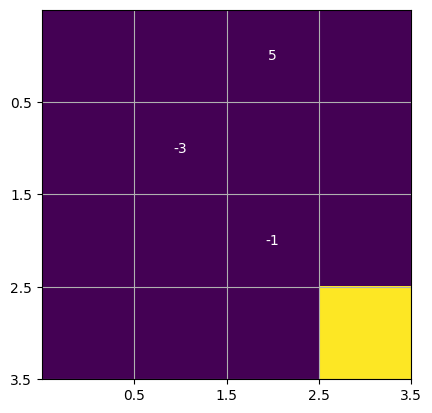

[[ 8.07867664  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.7951369   0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.42523134  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.97651993  2.0101209 ]
 [ 2.05855114  1.7746853   8.97169588  2.80265913]
 [ 0.          0.          9.9966701   0.        ]
 [ 0.          0.          0.          0.        ]]


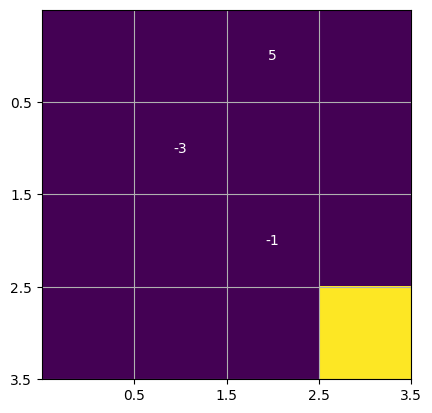

[[ 8.1523713   0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.84389403  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.450595    0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.98632056  2.0101209 ]
 [ 2.05855114  1.7746853   8.9742266   2.80265913]
 [ 0.          0.          9.99700309  0.        ]
 [ 0.          0.          0.          0.        ]]


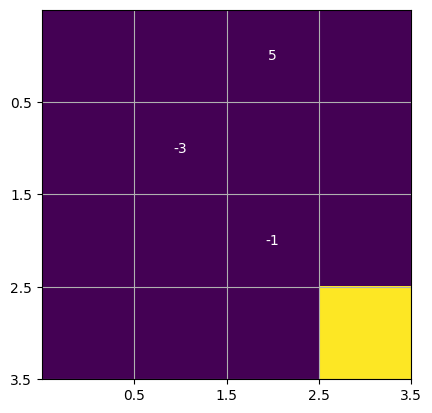

[[ 8.22308463  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.89005818  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.47430435  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 12.9953689   2.0101209 ]
 [ 2.05855114  1.7746853   8.97653422  2.80265913]
 [ 0.          0.          9.99730278  0.        ]
 [ 0.          0.          0.          0.        ]]


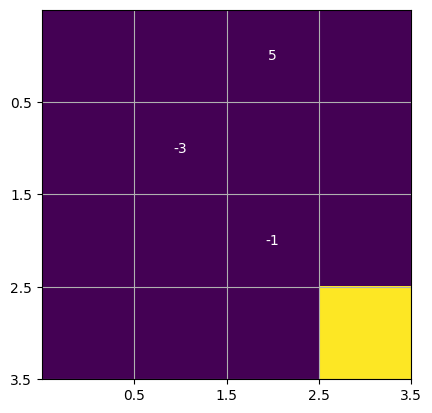

[[ 8.29088141  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.93373975  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.49645712  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.00372009  2.0101209 ]
 [ 2.05855114  1.7746853   8.97863805  2.80265913]
 [ 0.          0.          9.99757251  0.        ]
 [ 0.          0.          0.          0.        ]]


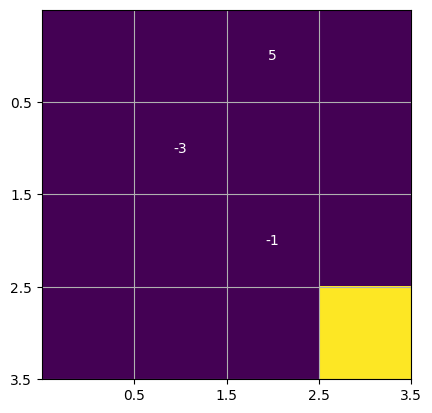

[[ 8.35582984  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.97504692  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.51714621  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.01142551  2.0101209 ]
 [ 2.05855114  1.7746853   8.98055577  2.80265913]
 [ 0.          0.          9.99781525  0.        ]
 [ 0.          0.          0.          0.        ]]


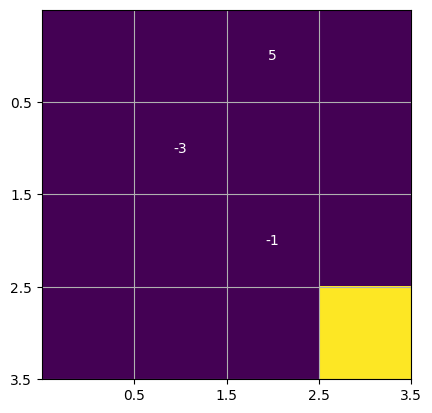

[[ 8.41800108  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.01408539  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.53645989  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.01853297  2.98013711]
 [ 2.05855114  1.7746853   8.98230357  2.80265913]
 [ 0.          0.          9.99803373  0.        ]
 [ 0.          0.          0.          0.        ]]


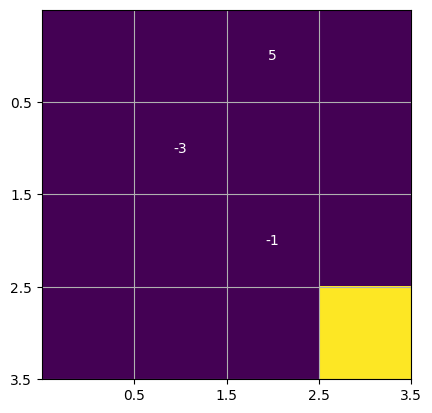

[[ 8.47746866  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.05095824  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.55448187  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.025087    2.98013711]
 [ 2.05855114  1.7746853   8.98389624  2.80265913]
 [ 0.          0.          9.99823036  0.        ]
 [ 0.          0.          0.          0.        ]]


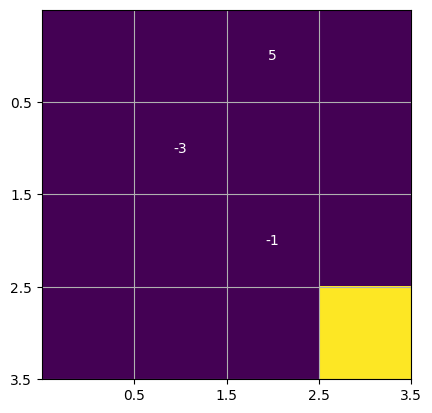

[[ 8.53430803  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.08576578  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.57129151  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.03112896  2.98013711]
 [ 2.05855114  1.7746853   8.98534735  2.80265913]
 [ 0.          0.          9.99840732  0.        ]
 [ 0.          0.          0.          0.        ]]


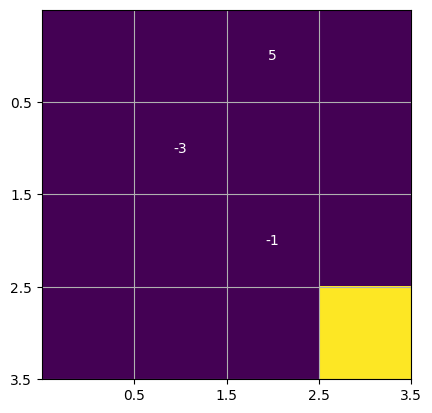

[[ 8.58859615  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.11860544  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.58696397  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.03669733  2.98013711]
 [ 2.05855114  1.7746853   8.98666928  2.80265913]
 [ 0.          0.          9.99856659  0.        ]
 [ 0.          0.          0.          0.        ]]


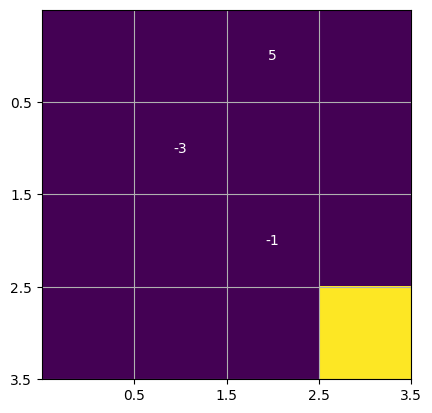

[[ 8.64041102  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.14957165  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.60157033  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.04182783  2.98013711]
 [ 2.05855114  1.7746853   8.98787334  2.80265913]
 [ 0.          0.          9.99870993  0.        ]
 [ 0.          0.          0.          0.        ]]


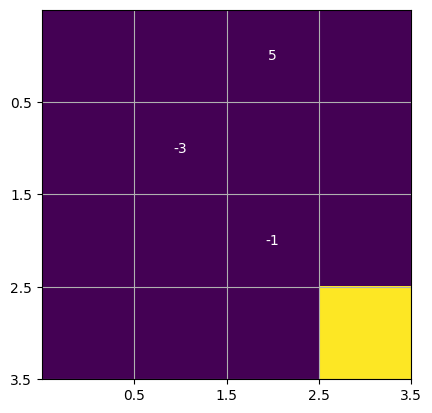

[[ 8.68983137  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.17875582  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.6151778   0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.04655365  2.98013711]
 [ 2.05855114  1.7746853   8.9889699   2.80265913]
 [ 0.          0.          9.99883894  0.        ]
 [ 0.          0.          0.          0.        ]]


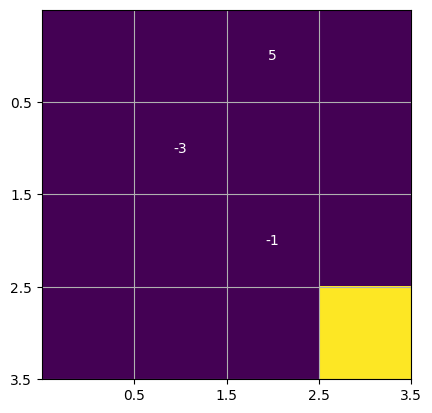

[[ 8.73693626  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.20624624  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.62784985  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.05090557  2.98013711]
 [ 2.05855114  1.7746853   8.98996842  2.80265913]
 [ 0.          0.          9.99895504  0.        ]
 [ 0.          0.          0.          0.        ]]


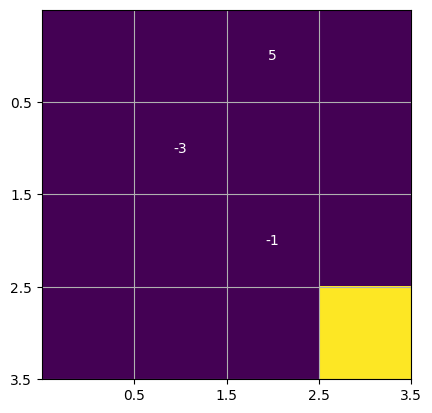

[[ 8.78180479  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.2321281   0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.63964636  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.05491217  2.98013711]
 [ 2.05855114  1.7746853   8.99087753  2.80265913]
 [ 0.          0.          9.99905954  0.        ]
 [ 0.          0.          0.          0.        ]]


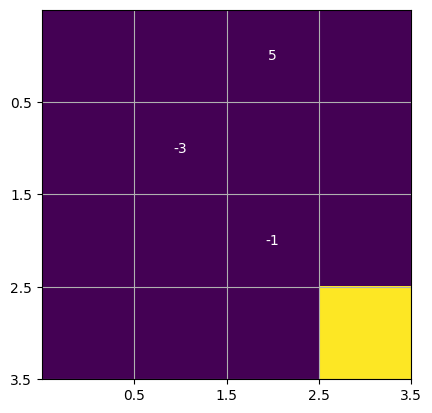

[[ 8.82451584  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.25648346  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.65062382  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.05859993  2.98013711]
 [ 2.05855114  1.7746853   8.99170513  2.80265913]
 [ 0.          0.          9.99915359  0.        ]
 [ 0.          0.          0.          0.        ]]


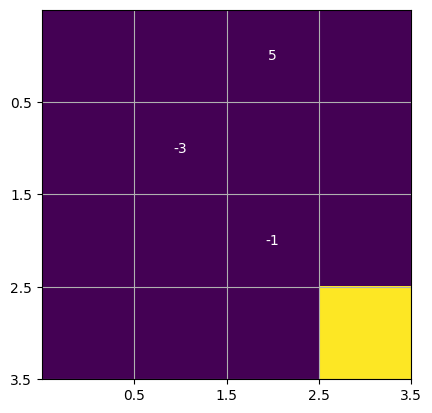

[[ 8.86514777  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.27939126  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.66083544  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.0619934   2.98013711]
 [ 2.05855114  1.7746853   8.99245844  2.80265913]
 [ 0.          0.          9.99923823  0.        ]
 [ 0.          0.          0.          0.        ]]


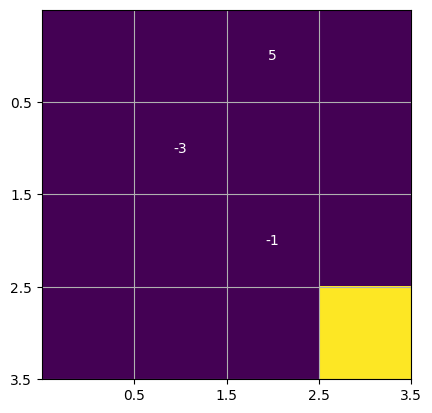

[[ 8.90377821  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.30092732  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.6703313   0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.06511532  2.98013711]
 [ 2.05855114  1.7746853   8.99314404  2.80265913]
 [ 0.          0.          9.9993144   0.        ]
 [ 0.          0.          0.          0.        ]]


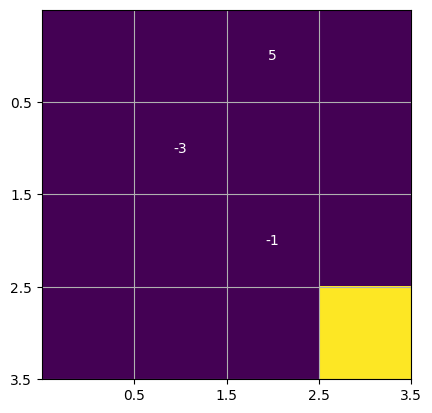

[[ 8.94048384  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.32116441  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.67915855  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.06798675  2.98013711]
 [ 2.05855114  1.7746853   8.99376793  2.80265913]
 [ 0.          0.          9.99938296  0.        ]
 [ 0.          0.          0.          0.        ]]


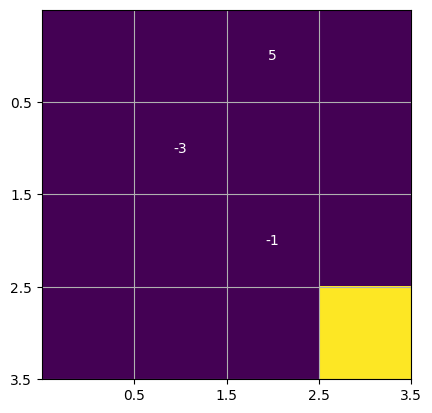

[[ 8.97534026  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.34017224  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.6873615   0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.07062719  2.98013711]
 [ 2.05855114  1.7746853   8.9943356   2.80265913]
 [ 0.          0.          9.99944467  0.        ]
 [ 0.          0.          0.          0.        ]]


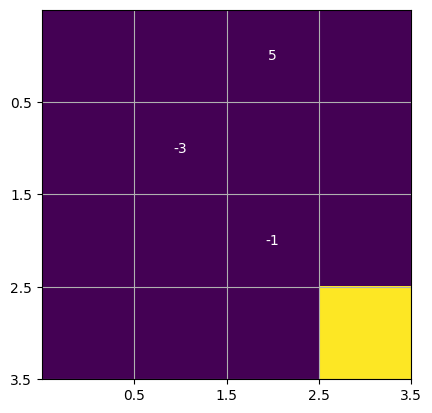

[[ 9.00842173  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.35801755  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.6949818   0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.07305468  2.98013711]
 [ 2.05855114  1.7746853   8.99485206  2.80265913]
 [ 0.          0.          9.9995002   0.        ]
 [ 0.          0.          0.          0.        ]]


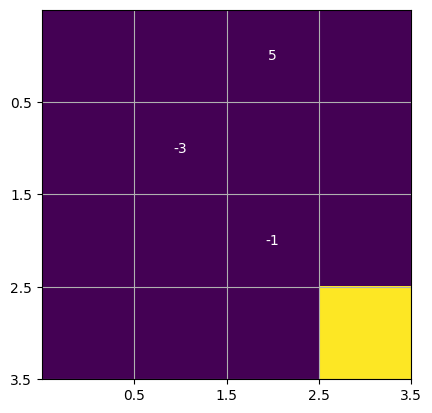

[[ 9.03980114  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.37476415  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.70205854  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.07528589  2.98013711]
 [ 2.05855114  1.7746853   8.99532188  2.80265913]
 [ 0.          0.          9.99955018  0.        ]
 [ 0.          0.          0.          0.        ]]


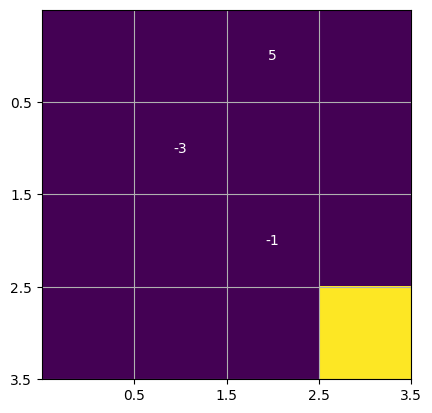

[[ 9.0695498   0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.39047301  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.70862842  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.07733627  2.98013711]
 [ 2.05855114  1.7746853   8.9957492   2.80265913]
 [ 0.          0.          9.99959516  0.        ]
 [ 0.          0.          0.          0.        ]]


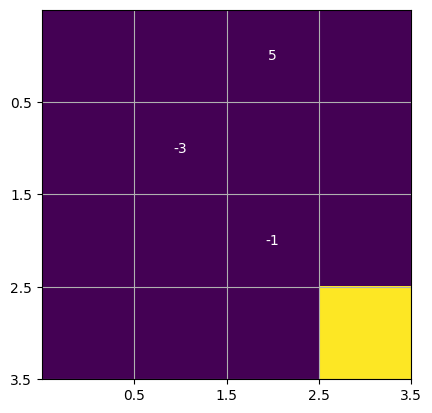

[[ 9.09773739  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.40520226  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.71472584  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.07922007  2.98013711]
 [ 2.05855114  1.7746853   8.99613785  2.80265913]
 [ 0.          0.          9.99963565  0.        ]
 [ 0.          0.          0.          0.        ]]


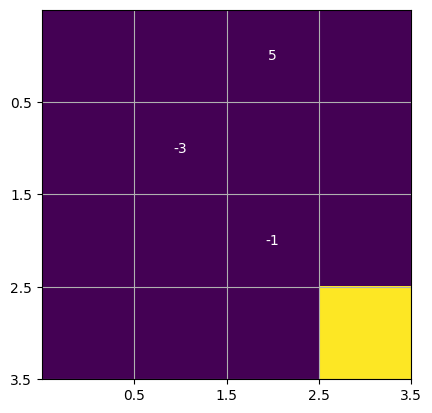

[[ 9.12443185  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.41900736  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.72038306  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.08095047  2.98013711]
 [ 2.05855114  1.7746853   8.99649127  2.80265913]
 [ 0.          0.          9.99967208  0.        ]
 [ 0.          0.          0.          0.        ]]


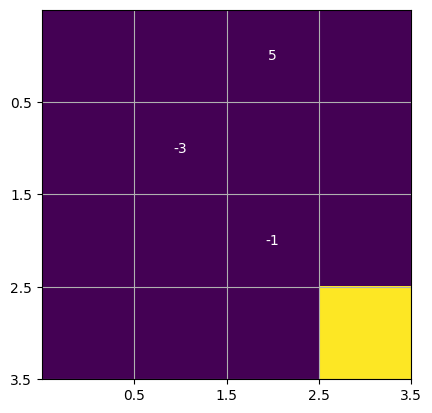

[[ 9.14969933  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.4319411   0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.7256303   0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.08253964  2.98013711]
 [ 2.05855114  1.7746853   8.99681263  2.80265913]
 [ 0.          0.          9.99970487  0.        ]
 [ 0.          0.          0.          0.        ]]


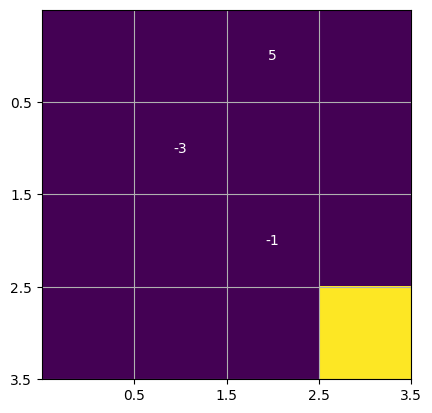

[[ 9.1736041   0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.44405372  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.73049584  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.08399881  2.98013711]
 [ 2.05855114  1.7746853   8.99710481  2.80265913]
 [ 0.          0.          9.99973439  0.        ]
 [ 0.          0.          0.          0.        ]]


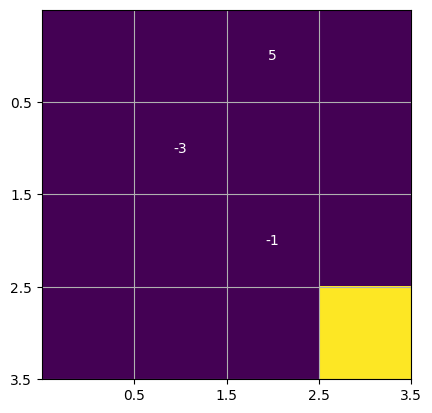

[[ 9.19620852  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.45539297  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.73500615  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.08533837  2.98013711]
 [ 2.05855114  1.7746853   8.99737042  2.80265913]
 [ 0.          0.          9.99976095  0.        ]
 [ 0.          0.          0.          0.        ]]


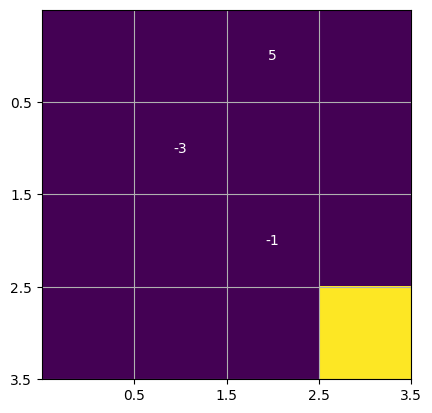

[[ 9.21757304  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.46600423  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.73918598  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.08656787  2.98013711]
 [ 2.05855114  1.7746853   8.99761186  2.80265913]
 [ 0.          0.          9.99978485  0.        ]
 [ 0.          0.          0.          0.        ]]


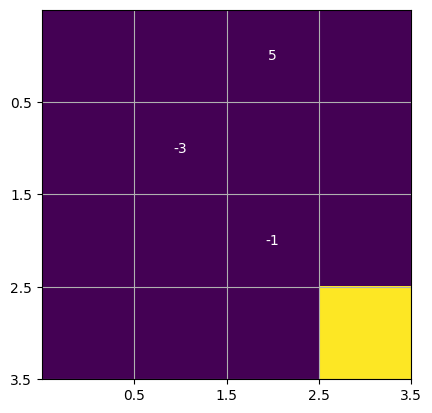

[[ 9.23775611  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.47593054  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.74305849  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.08769615  2.98013711]
 [ 2.05855114  1.7746853   8.99783131  2.80265913]
 [ 0.          0.          9.99980637  0.        ]
 [ 0.          0.          0.          0.        ]]


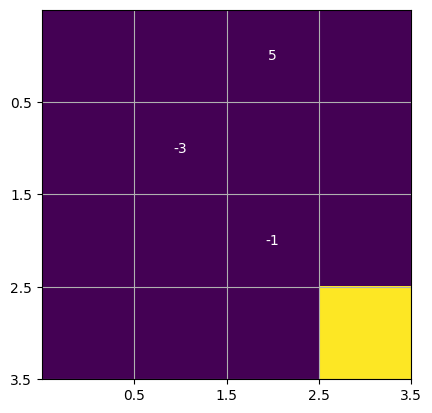

[[ 9.25681425  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.48521275  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.7466453   0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.08873135  2.98013711]
 [ 2.05855114  1.7746853   8.99803076  2.80265913]
 [ 0.          0.          9.99982573  0.        ]
 [ 0.          0.          0.          0.        ]]


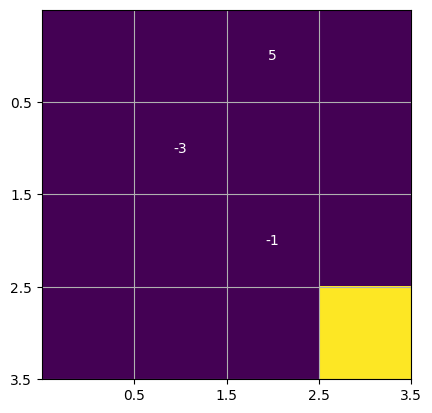

[[ 9.27480197  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.49388956  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.74996659  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.08968098  2.98013711]
 [ 2.05855114  1.7746853   8.998212    2.80265913]
 [ 0.          0.          9.99984316  0.        ]
 [ 0.          0.          0.          0.        ]]


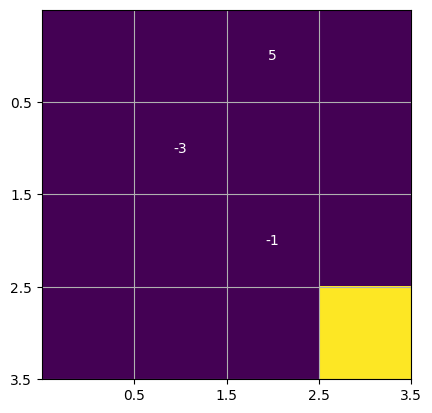

[[ 9.29177184  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.50199759  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.75304122  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.09055197  2.98013711]
 [ 2.05855114  1.7746853   8.99837668  2.80265913]
 [ 0.          0.          9.99985884  0.        ]
 [ 0.          0.          0.          0.        ]]


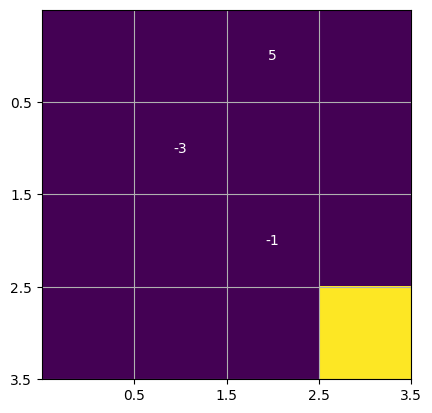

[[ 9.30777444  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.50957154  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.75588677  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.09135067  2.98013711]
 [ 2.05855114  1.7746853   8.99852631  2.80265913]
 [ 0.          0.          9.99987296  0.        ]
 [ 0.          0.          0.          0.        ]]


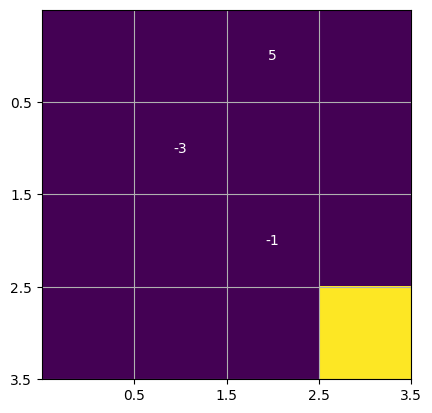

[[ 9.32285843  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.5166442   0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.75851966  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.09208297  2.98013711]
 [ 2.05855114  1.7746853   8.99866224  2.80265913]
 [ 0.          0.          9.99988566  0.        ]
 [ 0.          0.          0.          0.        ]]


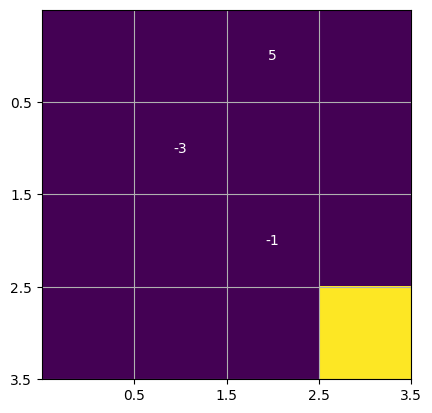

[[ 9.33707057  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.52324655  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.76095516  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.09275428  2.98013711]
 [ 2.05855114  1.7746853   8.99878573  2.80265913]
 [ 0.          0.          9.9998971   0.        ]
 [ 0.          0.          0.          0.        ]]


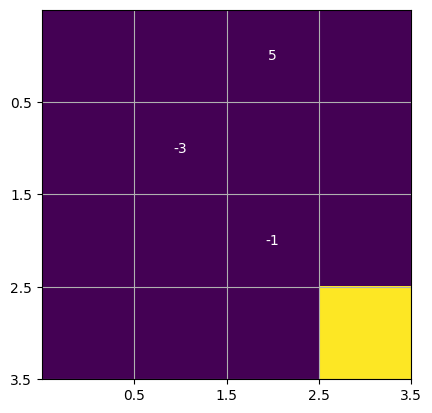

[[ 9.3504557   0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.52940786  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.76320753  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.09336956  2.98013711]
 [ 2.05855114  1.7746853   8.99889789  2.80265913]
 [ 0.          0.          9.99990739  0.        ]
 [ 0.          0.          0.          0.        ]]


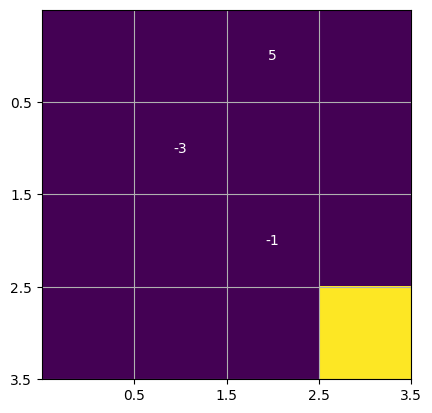

[[ 9.36305684  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.53515575  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.76529004  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.09393342  2.98013711]
 [ 2.05855114  1.7746853   8.99899977  2.80265913]
 [ 0.          0.          9.99991665  0.        ]
 [ 0.          0.          0.          0.        ]]


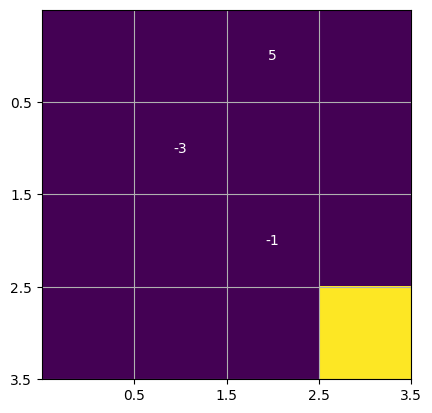

[[ 9.37491517  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.54051628  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.76721504  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.09445006  2.98013711]
 [ 2.05855114  1.7746853   8.99909229  2.80265913]
 [ 0.          0.          9.99992498  0.        ]
 [ 0.          0.          0.          0.        ]]


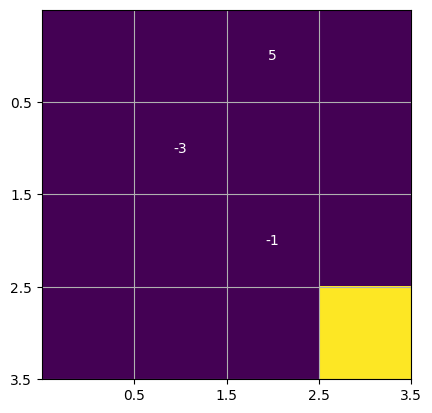

[[ 9.38607012  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.545514    0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.76899404  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.09492336  2.98013711]
 [ 2.05855114  1.7746853   8.99917631  2.80265913]
 [ 0.          0.          9.99993248  0.        ]
 [ 0.          0.          0.          0.        ]]


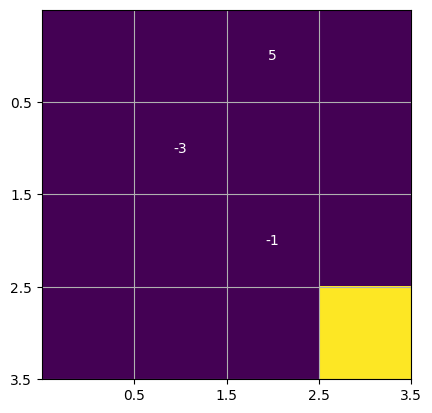

[[ 9.39655937  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.55017207  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.77063774  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.30673605  1.94532594 13.09535689  2.98013711]
 [ 2.05855114  1.7746853   8.9992526   2.80265913]
 [ 0.          0.          9.99993924  0.        ]
 [ 0.          0.          0.          0.        ]]


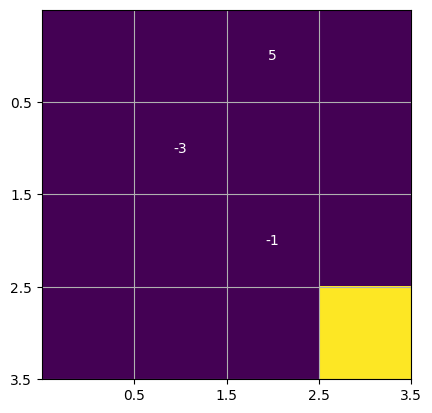

[[ 9.40641892  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.55451226  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.77215608  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09575393  2.98013711]
 [ 2.05855114  1.7746853   8.99932187  2.80265913]
 [ 0.          0.          9.99994531  0.        ]
 [ 0.          0.          0.          0.        ]]


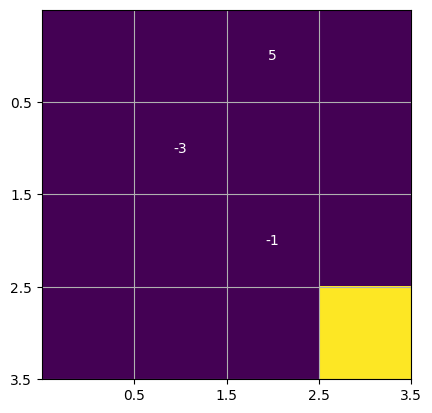

[[ 9.41568313  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.55855508  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.77355833  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09611751  2.98013711]
 [ 2.05855114  1.7746853   8.99938476  2.80265913]
 [ 0.          0.          9.99995078  0.        ]
 [ 0.          0.          0.          0.        ]]


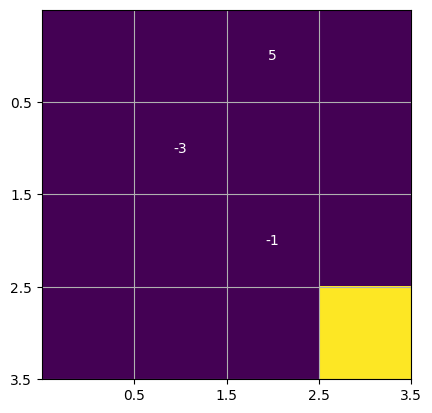

[[ 9.42438477  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.56231982  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.77485307  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09645039  2.98013711]
 [ 2.05855114  1.7746853   8.99944186  2.80265913]
 [ 0.          0.          9.9999557   0.        ]
 [ 0.          0.          0.          0.        ]]


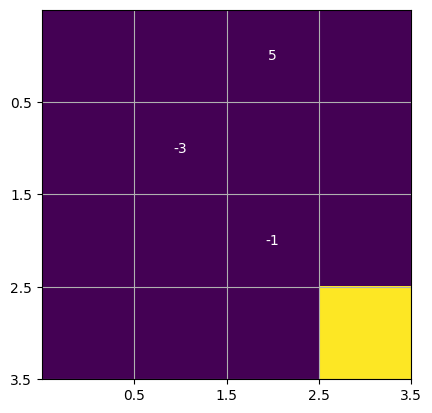

[[ 9.43255508  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.56582461  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.7760483   0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09675512  2.98013711]
 [ 2.05855114  1.7746853   8.99949369  2.80265913]
 [ 0.          0.          9.99996013  0.        ]
 [ 0.          0.          0.          0.        ]]


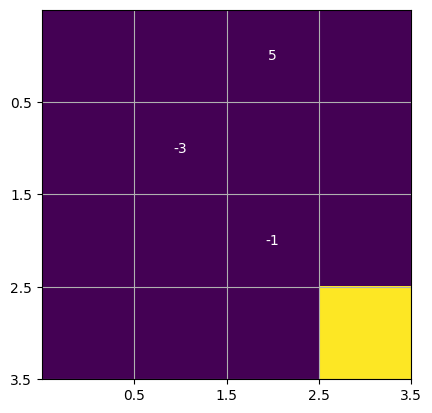

[[ 9.44022379  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.5690865   0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.77715143  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09703404  2.98013711]
 [ 2.05855114  1.7746853   8.99954073  2.80265913]
 [ 0.          0.          9.99996412  0.        ]
 [ 0.          0.          0.          0.        ]]


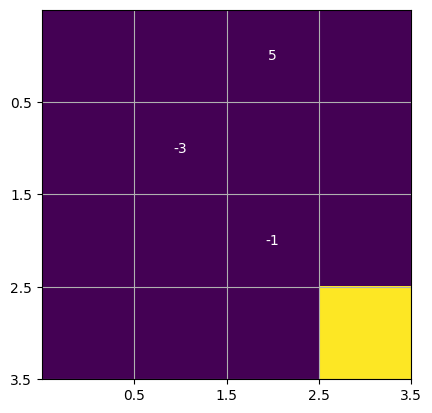

[[ 9.44741919  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.57212148  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.77816935  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.0972893   2.98013711]
 [ 2.05855114  1.7746853   8.99958343  2.80265913]
 [ 0.          0.          9.99996771  0.        ]
 [ 0.          0.          0.          0.        ]]


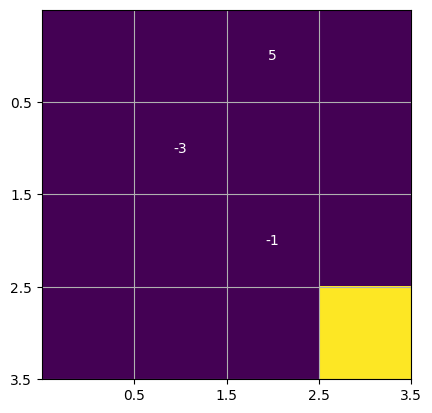

[[ 9.45416821  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.57494457  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.77910845  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09752288  2.98013711]
 [ 2.05855114  1.7746853   8.99962218  2.80265913]
 [ 0.          0.          9.99997094  0.        ]
 [ 0.          0.          0.          0.        ]]


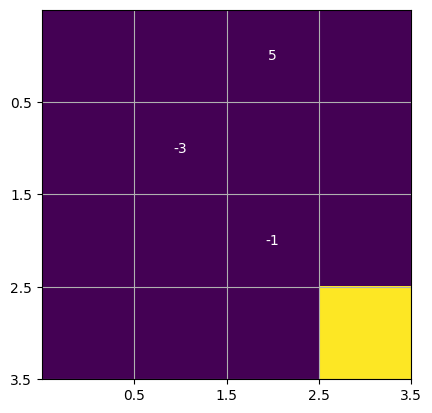

[[ 9.4604964   0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.57756988  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.77997467  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09773659  2.98013711]
 [ 2.05855114  1.7746853   8.99965734  2.80265913]
 [ 0.          0.          9.99997384  0.        ]
 [ 0.          0.          0.          0.        ]]


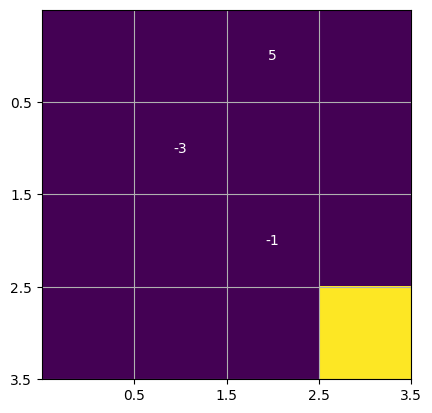

[[ 9.46642805  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.58001061  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78077349  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09793209  2.98013711]
 [ 2.05855114  1.7746853   8.99968926  2.80265913]
 [ 0.          0.          9.99997646  0.        ]
 [ 0.          0.          0.          0.        ]]


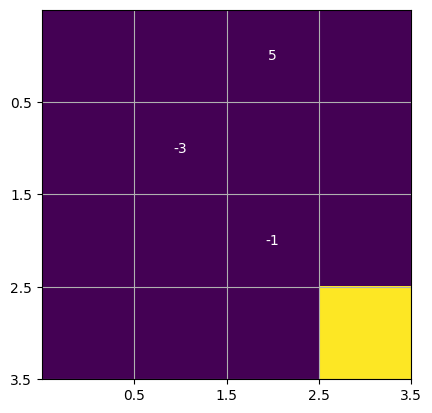

[[ 9.4719862   0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.58227916  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78151003  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09811091  2.98013711]
 [ 2.05855114  1.7746853   8.99971821  2.80265913]
 [ 0.          0.          9.99997881  0.        ]
 [ 0.          0.          0.          0.        ]]


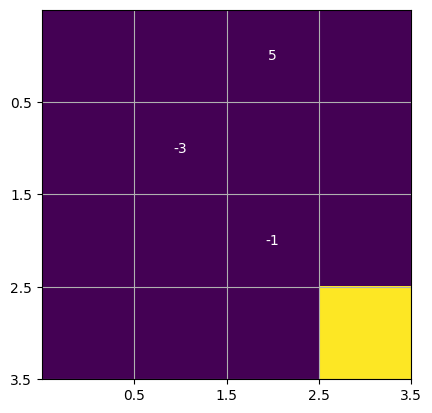

[[ 9.4771927   0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.58438715  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78218901  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09827446  2.98013711]
 [ 2.05855114  1.7746853   8.99974448  2.80265913]
 [ 0.          0.          9.99998093  0.        ]
 [ 0.          0.          0.          0.        ]]


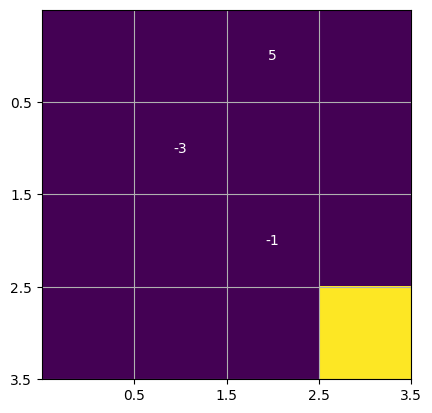

[[ 9.48206827  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.58634544  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78281481  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09842402  2.98013711]
 [ 2.05855114  1.7746853   8.99976832  2.80265913]
 [ 0.          0.          9.99998284  0.        ]
 [ 0.          0.          0.          0.        ]]


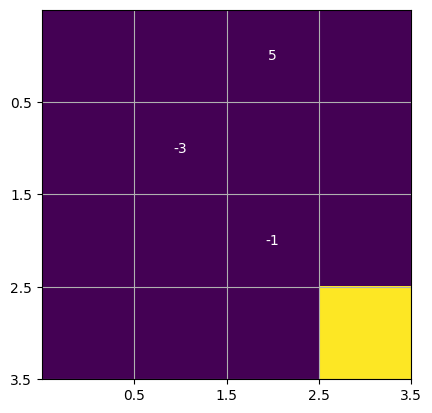

[[ 9.48663254  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.58816423  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78339149  0.21565579  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09856076  2.98013711]
 [ 2.05855114  1.7746853   8.99978994  2.80265913]
 [ 0.          0.          9.99998455  0.        ]
 [ 0.          0.          0.          0.        ]]


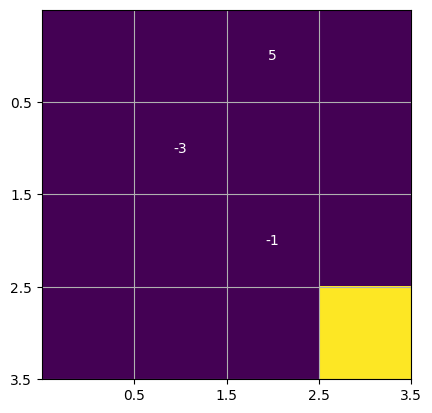

[[ 9.49090406  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.59137297  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78392281  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09868578  2.98013711]
 [ 2.05855114  1.7746853   8.99980956  2.80265913]
 [ 0.          0.          9.9999861   0.        ]
 [ 0.          0.          0.          0.        ]]


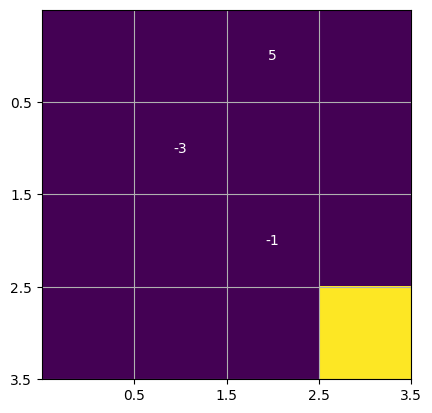

[[ 9.49503723  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.59278873  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78441225  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09880006  2.98013711]
 [ 2.05855114  1.7746853   8.99982735  2.80265913]
 [ 0.          0.          9.99998749  0.        ]
 [ 0.          0.          0.          0.        ]]


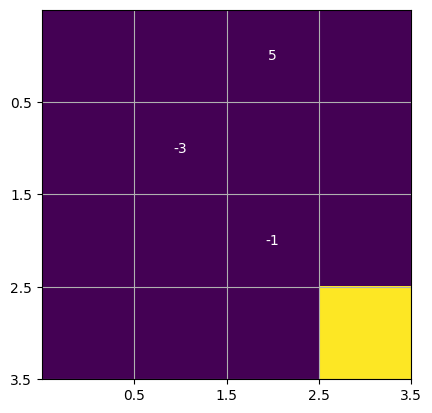

[[ 9.49888449  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.59410696  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78486303  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09890452  2.98013711]
 [ 2.05855114  1.7746853   8.99984349  2.80265913]
 [ 0.          0.          9.99998874  0.        ]
 [ 0.          0.          0.          0.        ]]


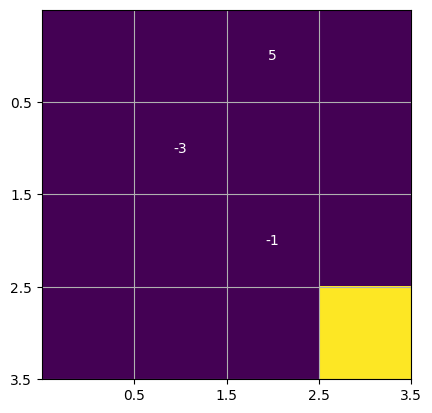

[[ 9.50246567  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.59533394  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78527813  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09899998  2.98013711]
 [ 2.05855114  1.7746853   8.99985813  2.80265913]
 [ 0.          0.          9.99998987  0.        ]
 [ 0.          0.          0.          0.        ]]


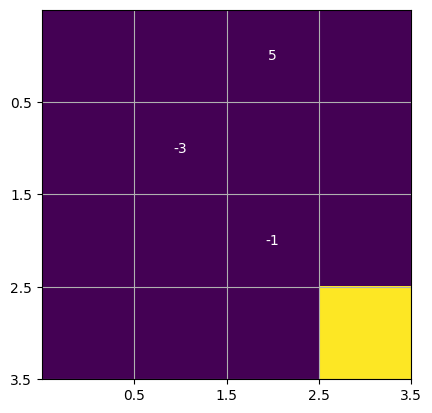

[[ 9.50579915  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.59647557  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78566032  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09908722  2.98013711]
 [ 2.05855114  1.7746853   8.9998714   2.80265913]
 [ 0.          0.          9.99999088  0.        ]
 [ 0.          0.          0.          0.        ]]


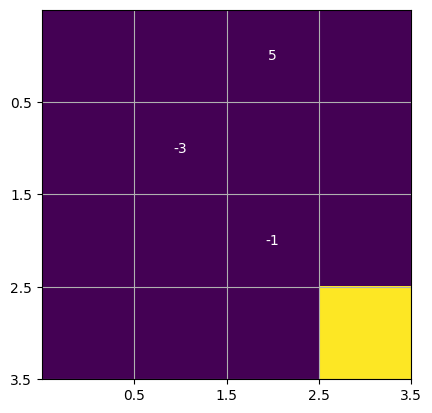

[[ 9.50890204  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.59753745  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78601214  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09916692  2.98013711]
 [ 2.05855114  1.7746853   8.99988344  2.80265913]
 [ 0.          0.          9.99999179  0.        ]
 [ 0.          0.          0.          0.        ]]


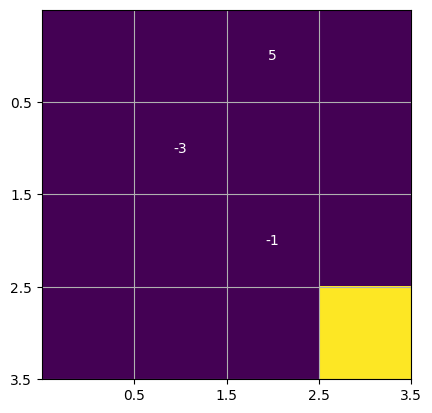

[[ 9.51179021  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.59852479  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78633595  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09923974  2.98013711]
 [ 2.05855114  1.7746853   8.99989436  2.80265913]
 [ 0.          0.          9.99999261  0.        ]
 [ 0.          0.          0.          0.        ]]


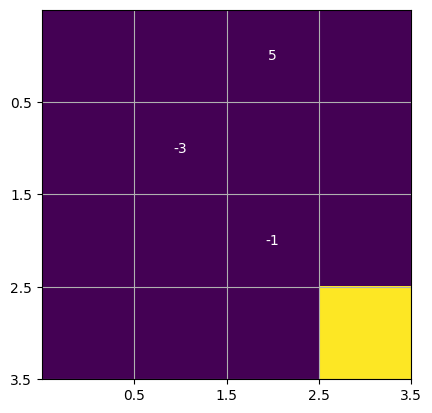

[[ 9.51447842  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.59944255  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78663393  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09930626  2.98013711]
 [ 2.05855114  1.7746853   8.99990426  2.80265913]
 [ 0.          0.          9.99999335  0.        ]
 [ 0.          0.          0.          0.        ]]


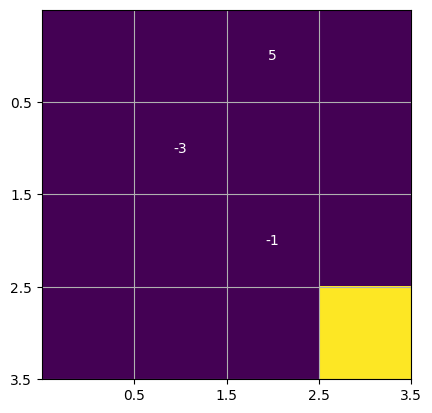

[[ 9.5169804   0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60029535  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.7869081   1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09936701  2.98013711]
 [ 2.05855114  1.7746853   8.99991323  2.80265913]
 [ 0.          0.          9.99999402  0.        ]
 [ 0.          0.          0.          0.        ]]


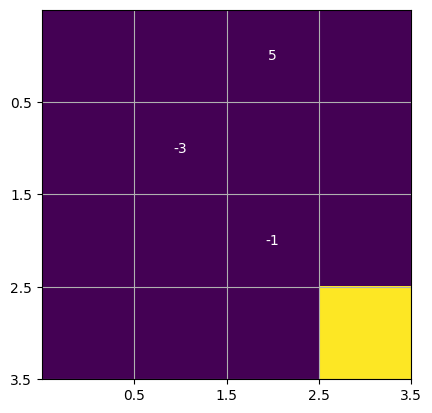

[[ 9.51930895  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60108754  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78716032  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.0994225   2.98013711]
 [ 2.05855114  1.7746853   8.99992137  2.80265913]
 [ 0.          0.          9.99999461  0.        ]
 [ 0.          0.          0.          0.        ]]


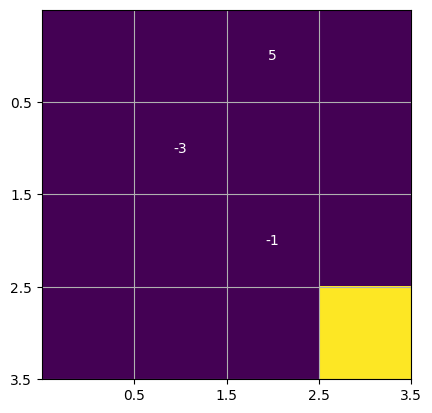

[[ 9.52147593  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60182322  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78739231  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09947318  2.98013711]
 [ 2.05855114  1.7746853   8.99992875  2.80265913]
 [ 0.          0.          9.99999515  0.        ]
 [ 0.          0.          0.          0.        ]]


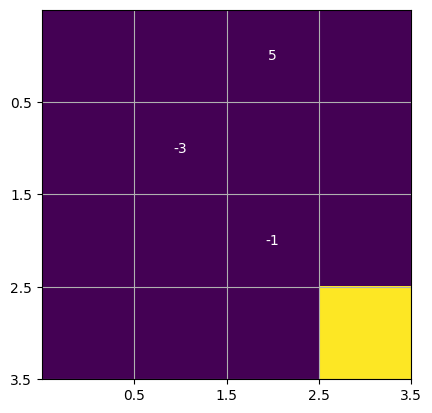

[[ 9.52349243  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.6025062   0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78760567  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09951945  2.98013711]
 [ 2.05855114  1.7746853   8.99993544  2.80265913]
 [ 0.          0.          9.99999564  0.        ]
 [ 0.          0.          0.          0.        ]]


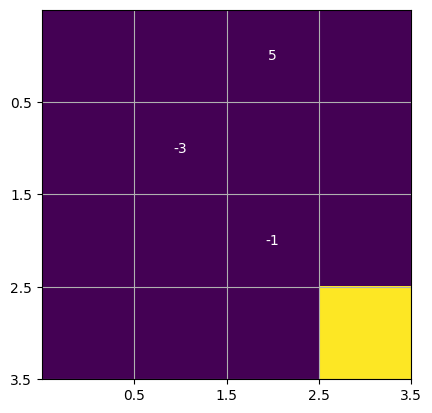

[[ 9.52536874  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60314009  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78780185  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09956169  2.98013711]
 [ 2.05855114  1.7746853   8.9999415   2.80265913]
 [ 0.          0.          9.99999607  0.        ]
 [ 0.          0.          0.          0.        ]]


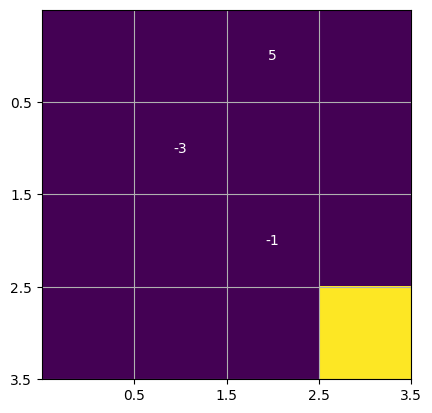

[[ 9.52711448  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60372825  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78798222  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09960026  2.98013711]
 [ 2.05855114  1.7746853   8.999947    2.80265913]
 [ 0.          0.          9.99999647  0.        ]
 [ 0.          0.          0.          0.        ]]


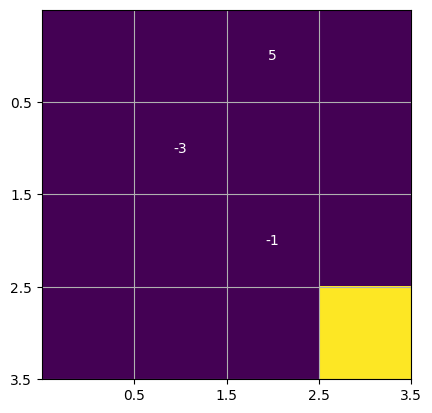

[[ 9.52873857  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60427382  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78814802  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09963546  2.98013711]
 [ 2.05855114  1.7746853   8.99995198  2.80265913]
 [ 0.          0.          9.99999682  0.        ]
 [ 0.          0.          0.          0.        ]]


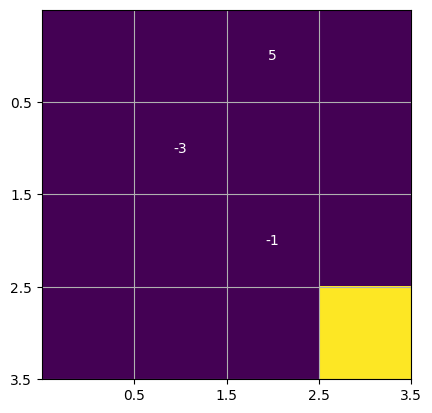

[[ 9.53024936  0.18644474  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60477976  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78830041  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09966759  2.98013711]
 [ 2.05855114  1.7746853   8.9999565   2.80265913]
 [ 0.          0.          9.99999714  0.        ]
 [ 0.          0.          0.          0.        ]]


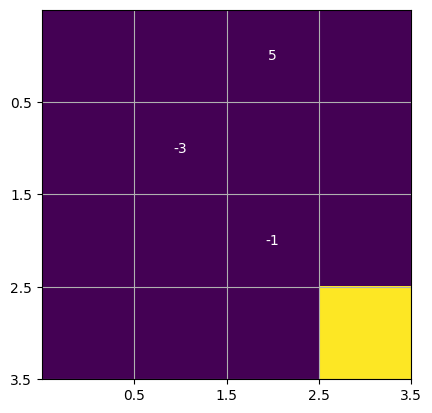

[[ 9.5316546   1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60524882  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78844045  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09969692  2.98013711]
 [ 2.05855114  1.7746853   8.99996059  2.80265913]
 [ 0.          0.          9.99999742  0.        ]
 [ 0.          0.          0.          0.        ]]


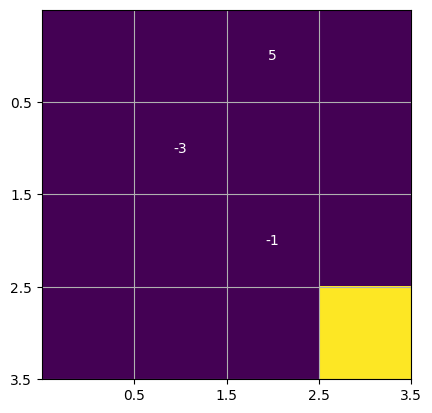

[[ 9.53296154  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60568358  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78856913  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09972368  2.98013711]
 [ 2.05855114  1.7746853   8.9999643   2.80265913]
 [ 0.          0.          9.99999768  0.        ]
 [ 0.          0.          0.          0.        ]]


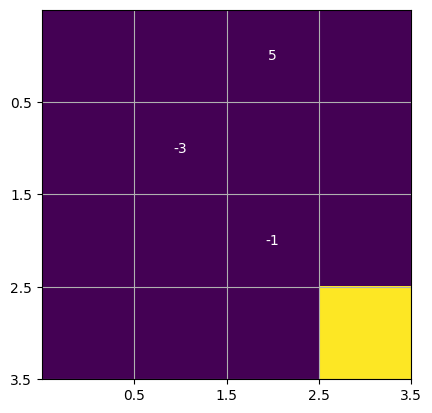

[[ 9.5341769   1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60608645  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78868735  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.0997481   2.98013711]
 [ 2.05855114  1.7746853   8.99996766  2.80265913]
 [ 0.          0.          9.99999791  0.        ]
 [ 0.          0.          0.          0.        ]]


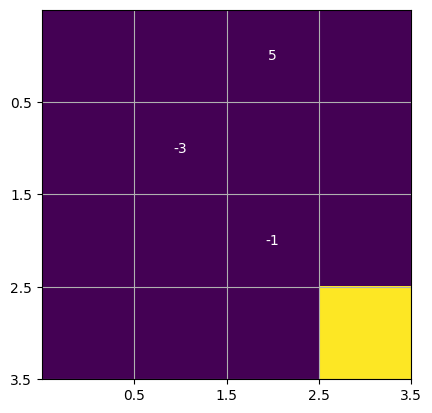

[[ 9.53530699  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60645966  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78879594  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09977038  2.98013711]
 [ 2.05855114  1.7746853   8.99997071  2.80265913]
 [ 0.          0.          9.99999812  0.        ]
 [ 0.          0.          0.          0.        ]]


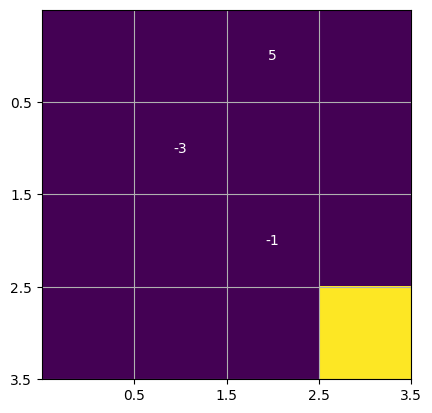

[[ 9.53635766  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60680533  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78889568  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.0997907   2.98013711]
 [ 2.05855114  1.7746853   8.99997347  2.80265913]
 [ 0.          0.          9.99999831  0.        ]
 [ 0.          0.          0.          0.        ]]


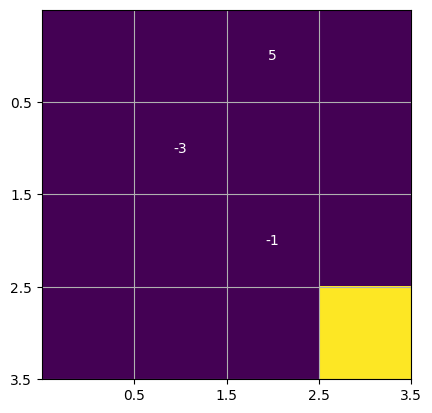

[[ 9.53733438  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60712541  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78898728  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09980925  2.98013711]
 [ 2.05855114  1.7746853   8.99997597  2.80265913]
 [ 0.          0.          9.99999848  0.        ]
 [ 0.          0.          0.          0.        ]]


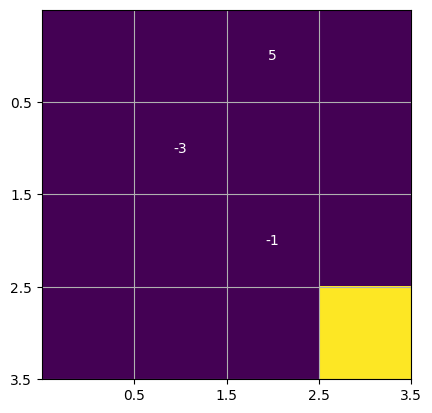

[[ 9.53824223  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60742172  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78907138  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09982616  2.98013711]
 [ 2.05855114  1.7746853   8.99997823  2.80265913]
 [ 0.          0.          9.99999863  0.        ]
 [ 0.          0.          0.          0.        ]]


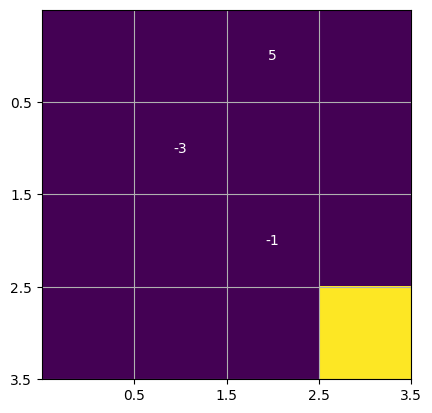

[[ 9.53908596  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60769598  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.7891486   1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09984158  2.98013711]
 [ 2.05855114  1.7746853   8.99998029  2.80265913]
 [ 0.          0.          9.99999877  0.        ]
 [ 0.          0.          0.          0.        ]]


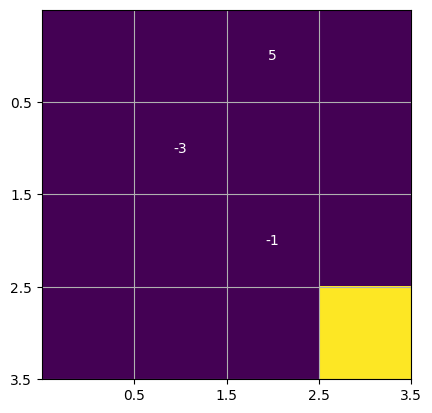

[[ 9.53987     1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60794975  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78921948  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09985565  2.98013711]
 [ 2.05855114  1.7746853   8.99998215  2.80265913]
 [ 0.          0.          9.99999889  0.        ]
 [ 0.          0.          0.          0.        ]]


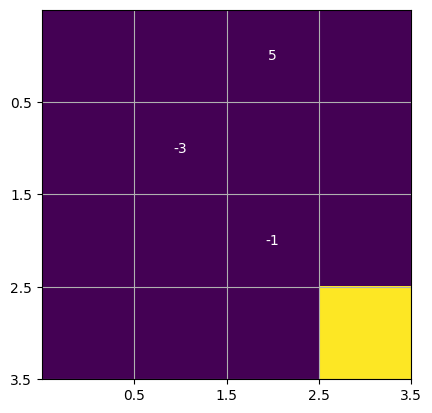

[[ 9.54059848  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60818453  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78928454  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09986848  2.98013711]
 [ 2.05855114  1.7746853   8.99998383  2.80265913]
 [ 0.          0.          9.999999    0.        ]
 [ 0.          0.          0.          0.        ]]


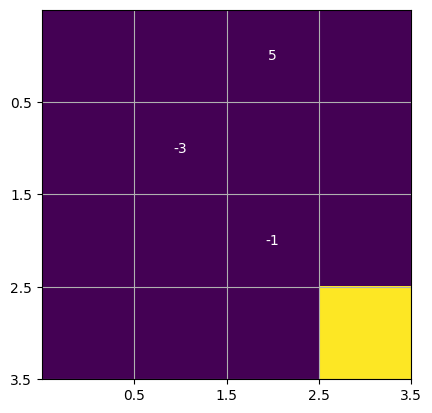

[[ 9.54127524  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60840169  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78934425  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09988018  2.98013711]
 [ 2.05855114  1.7746853   8.99998536  2.80265913]
 [ 0.          0.          9.9999991   0.        ]
 [ 0.          0.          0.          0.        ]]


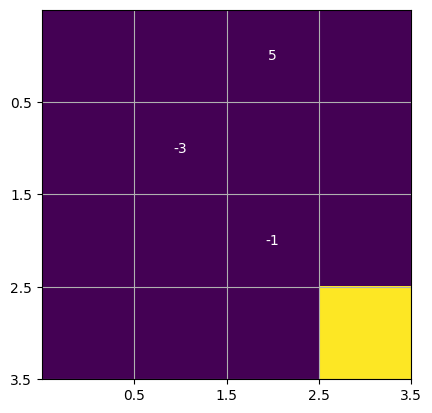

[[ 9.54190387  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.6086025   0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78939904  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09989084  2.98013711]
 [ 2.05855114  1.7746853   8.99998674  2.80265913]
 [ 0.          0.          9.99999919  0.        ]
 [ 0.          0.          0.          0.        ]]


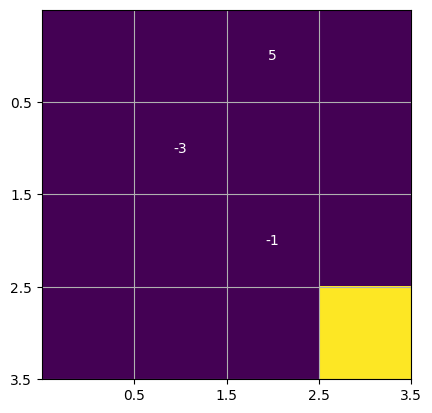

[[ 9.5424877   1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60878816  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78944931  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09990056  2.98013711]
 [ 2.05855114  1.7746853   8.999988    2.80265913]
 [ 0.          0.          9.99999927  0.        ]
 [ 0.          0.          0.          0.        ]]


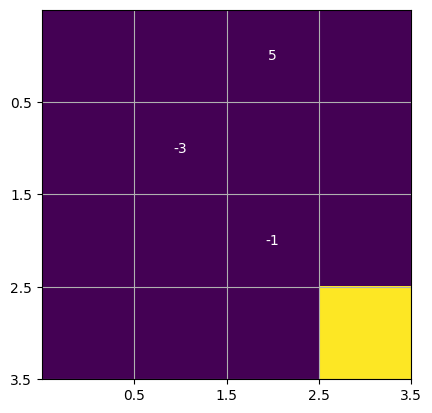

[[ 9.54302987  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60895978  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78949543  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09990943  2.98013711]
 [ 2.05855114  1.7746853   8.99998913  2.80265913]
 [ 0.          0.          9.99999935  0.        ]
 [ 0.          0.          0.          0.        ]]


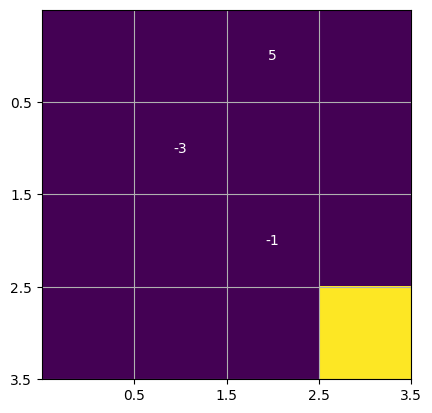

[[ 9.54353326  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.6091184   0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78953774  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09991751  2.98013711]
 [ 2.05855114  1.7746853   8.99999016  2.80265913]
 [ 0.          0.          9.99999941  0.        ]
 [ 0.          0.          0.          0.        ]]


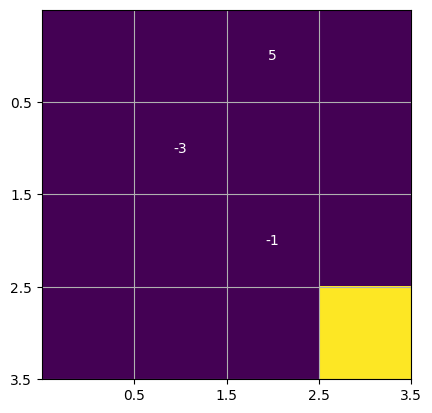

[[ 9.54400059  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60926495  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78957654  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09992487  2.98013711]
 [ 2.05855114  1.7746853   8.99999109  2.80265913]
 [ 0.          0.          9.99999947  0.        ]
 [ 0.          0.          0.          0.        ]]


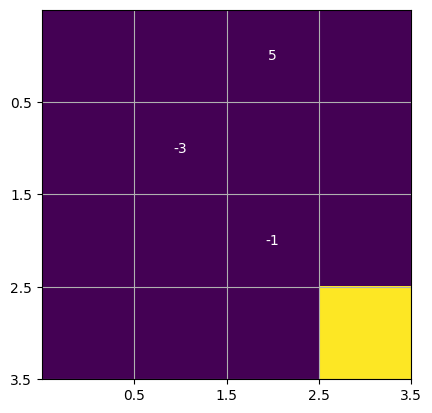

[[ 9.54443438  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60940035  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78961212  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09993158  2.98013711]
 [ 2.05855114  1.7746853   8.99999193  2.80265913]
 [ 0.          0.          9.99999952  0.        ]
 [ 0.          0.          0.          0.        ]]


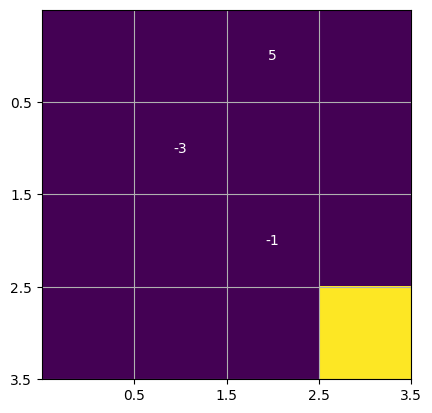

[[ 9.54483697  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.6095254   0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78964475  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.0999377   2.98013711]
 [ 2.05855114  1.7746853   8.9999927   2.80265913]
 [ 0.          0.          9.99999957  0.        ]
 [ 0.          0.          0.          0.        ]]


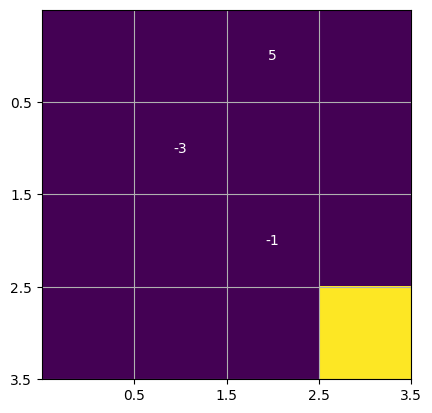

[[ 9.54521056  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60964089  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78967467  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09994327  2.98013711]
 [ 2.05855114  1.7746853   8.99999339  2.80265913]
 [ 0.          0.          9.99999961  0.        ]
 [ 0.          0.          0.          0.        ]]


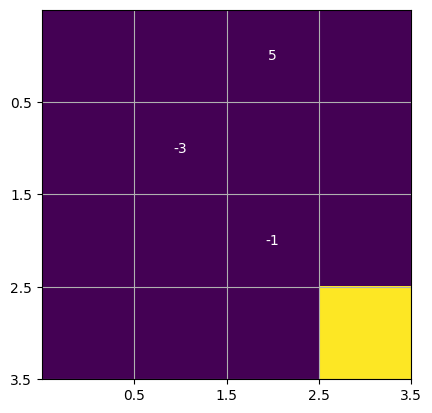

[[ 9.54555718  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60974752  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.7897021   1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09994835  2.98013711]
 [ 2.05855114  1.7746853   8.99999402  2.80265913]
 [ 0.          0.          9.99999965  0.        ]
 [ 0.          0.          0.          0.        ]]


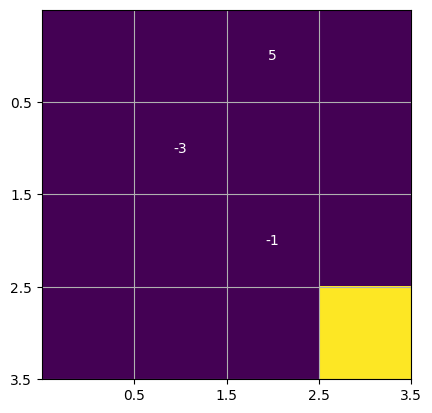

[[ 9.54587874  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60984596  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78972724  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09995297  2.98013711]
 [ 2.05855114  1.7746853   8.99999458  2.80265913]
 [ 0.          0.          9.99999969  0.        ]
 [ 0.          0.          0.          0.        ]]


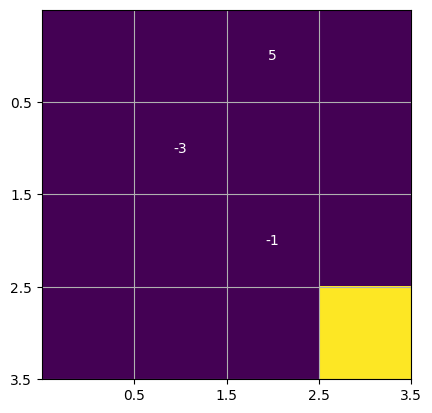

[[ 9.546177    1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.60993681  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78975028  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09995719  2.98013711]
 [ 2.05855114  1.7746853   8.9999951   2.80265913]
 [ 0.          0.          9.99999972  0.        ]
 [ 0.          0.          0.          0.        ]]


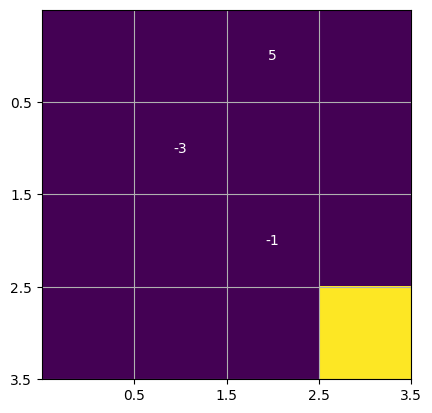

[[ 9.54645362  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61002066  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.7897714   1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09996103  2.98013711]
 [ 2.05855114  1.7746853   8.99999556  2.80265913]
 [ 0.          0.          9.99999975  0.        ]
 [ 0.          0.          0.          0.        ]]


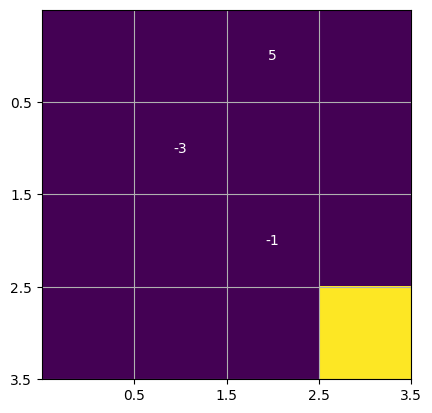

[[ 9.54671012  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61009802  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78979075  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09996453  2.98013711]
 [ 2.05855114  1.7746853   8.99999598  2.80265913]
 [ 0.          0.          9.99999977  0.        ]
 [ 0.          0.          0.          0.        ]]


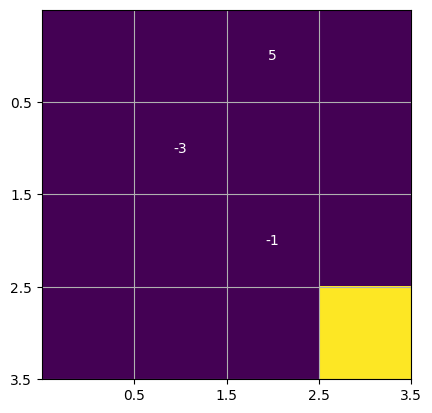

[[ 9.54694793  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61016938  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78980849  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09996771  2.98013711]
 [ 2.05855114  1.7746853   8.99999636  2.80265913]
 [ 0.          0.          9.99999979  0.        ]
 [ 0.          0.          0.          0.        ]]


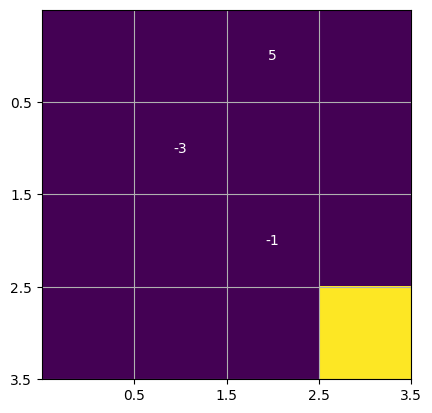

[[ 9.54716838  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61023521  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78982473  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09997061  2.98013711]
 [ 2.05855114  1.7746853   8.99999671  2.80265913]
 [ 0.          0.          9.99999982  0.        ]
 [ 0.          0.          0.          0.        ]]


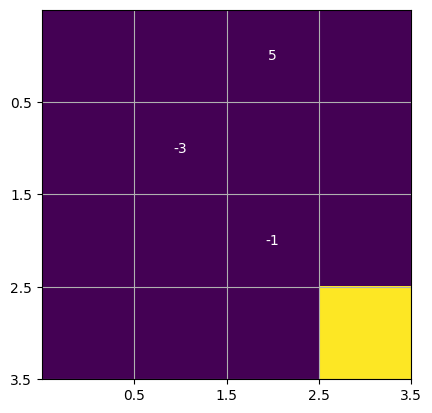

[[ 9.54737271  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61029591  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78983961  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09997326  2.98013711]
 [ 2.05855114  1.7746853   8.99999702  2.80265913]
 [ 0.          0.          9.99999983  0.        ]
 [ 0.          0.          0.          0.        ]]


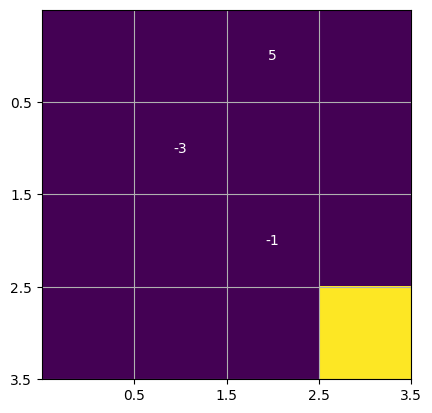

[[ 9.54756207  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61035189  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78985325  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09997566  2.98013711]
 [ 2.05855114  1.7746853   8.9999973   2.80265913]
 [ 0.          0.          9.99999985  0.        ]
 [ 0.          0.          0.          0.        ]]


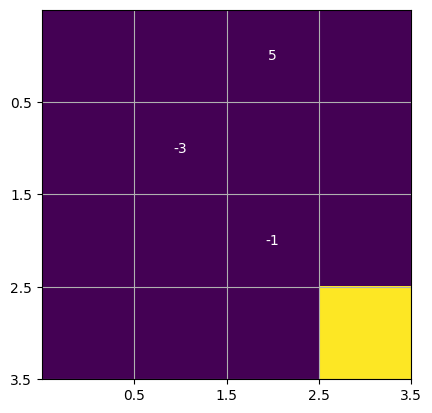

[[ 9.54773753  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61040349  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78986573  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09997785  2.98013711]
 [ 2.05855114  1.7746853   8.99999756  2.80265913]
 [ 0.          0.          9.99999987  0.        ]
 [ 0.          0.          0.          0.        ]]


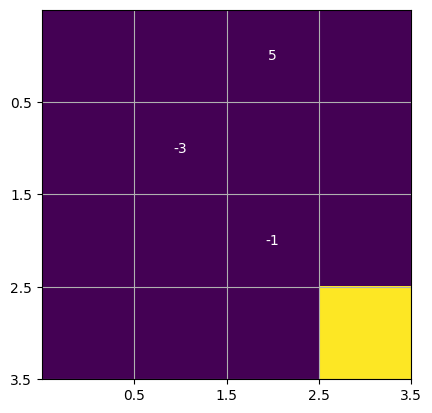

[[ 9.54790009  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61045106  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78987716  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09997985  2.98013711]
 [ 2.05855114  1.7746853   8.99999779  2.80265913]
 [ 0.          0.          9.99999988  0.        ]
 [ 0.          0.          0.          0.        ]]


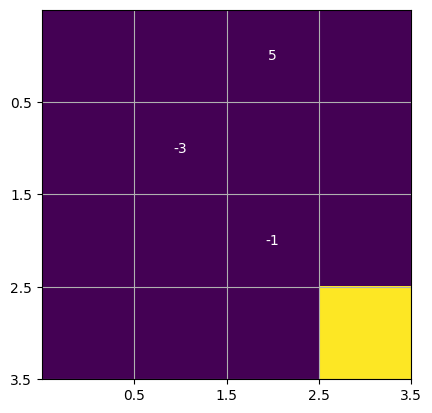

[[ 9.54805068  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.6104949   0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78988763  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09998167  2.98013711]
 [ 2.05855114  1.7746853   8.999998    2.80265913]
 [ 0.          0.          9.99999989  0.        ]
 [ 0.          0.          0.          0.        ]]


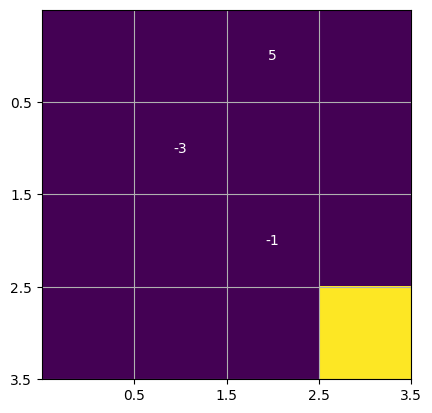

[[ 9.54819015  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61053529  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78989722  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09998332  2.98013711]
 [ 2.05855114  1.7746853   8.99999819  2.80265913]
 [ 0.          0.          9.9999999   0.        ]
 [ 0.          0.          0.          0.        ]]


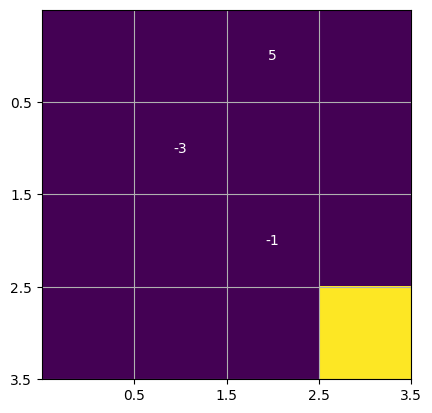

[[ 9.54831931  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61057251  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.789906    1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09998482  2.98013711]
 [ 2.05855114  1.7746853   8.99999836  2.80265913]
 [ 0.          0.          9.99999991  0.        ]
 [ 0.          0.          0.          0.        ]]


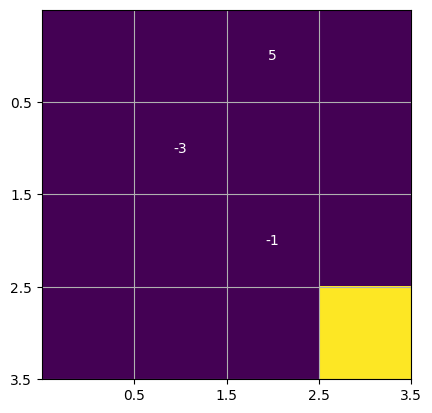

[[ 9.54843891  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.6106068   0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78991403  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09998619  2.98013711]
 [ 2.05855114  1.7746853   8.99999852  2.80265913]
 [ 0.          0.          9.99999992  0.        ]
 [ 0.          0.          0.          0.        ]]


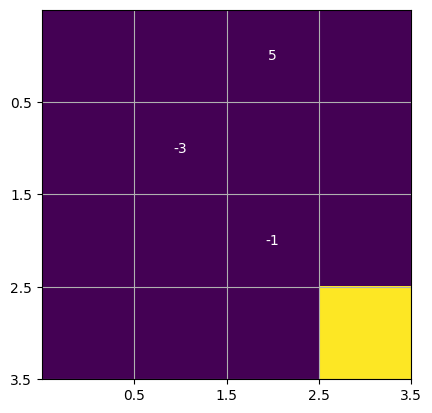

[[ 9.54854963  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61063839  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78992139  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09998744  2.98013711]
 [ 2.05855114  1.7746853   8.99999866  2.80265913]
 [ 0.          0.          9.99999993  0.        ]
 [ 0.          0.          0.          0.        ]]


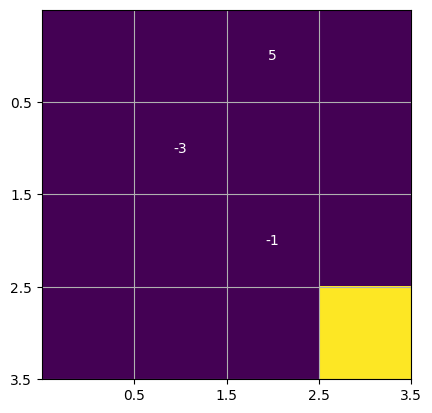

[[ 9.54865212  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61066747  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78992812  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09998858  2.98013711]
 [ 2.05855114  1.7746853   8.99999879  2.80265913]
 [ 0.          0.          9.99999994  0.        ]
 [ 0.          0.          0.          0.        ]]


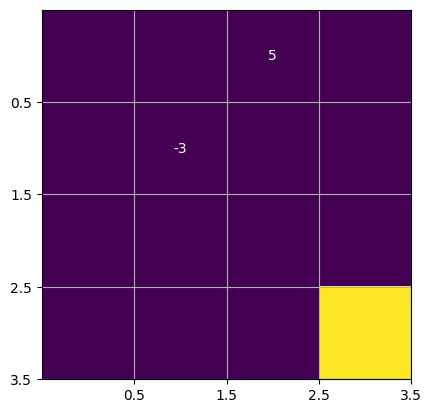

[[ 9.54874698  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61069426  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78993428  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.89999999  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09998961  2.98013711]
 [ 2.05855114  1.7746853   8.9999989   2.80265913]
 [ 0.         -0.1         9.99999994  0.        ]
 [ 0.          0.          0.          0.        ]]


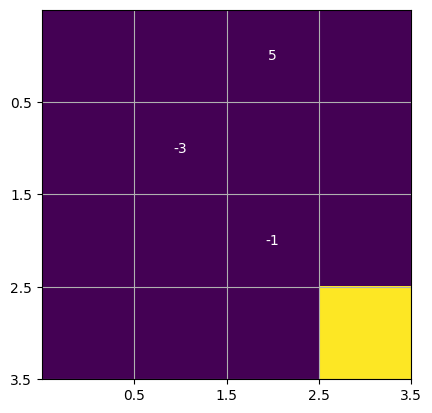

[[ 9.54883477  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61071891  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78993991  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.89999999  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09999055  2.98013711]
 [ 2.05855114  1.7746853   8.99999901  2.80265913]
 [ 0.         -0.1         9.99999995  0.        ]
 [ 0.          0.          0.          0.        ]]


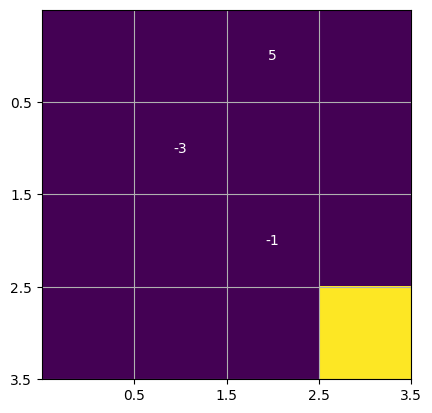

[[ 9.54891599  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61074162  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78994507  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.89999999  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09999141  2.98013711]
 [ 2.05855114  1.7746853   8.9999991   2.80265913]
 [ 0.         -0.1         9.99999995  0.        ]
 [ 0.          0.          0.          0.        ]]


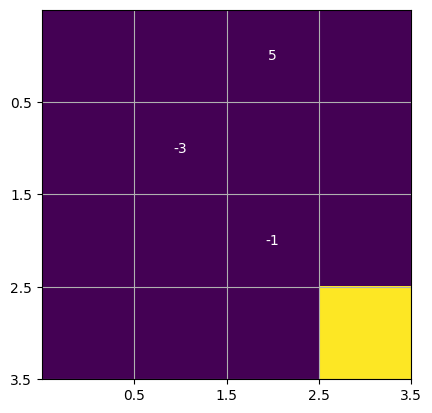

[[ 9.54899114  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61076251  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78994979  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.89999999  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09999218  2.98013711]
 [ 2.05855114  1.7746853   8.99999919  2.80265913]
 [ 0.         -0.1         9.99999996  0.        ]
 [ 0.          0.          0.          0.        ]]


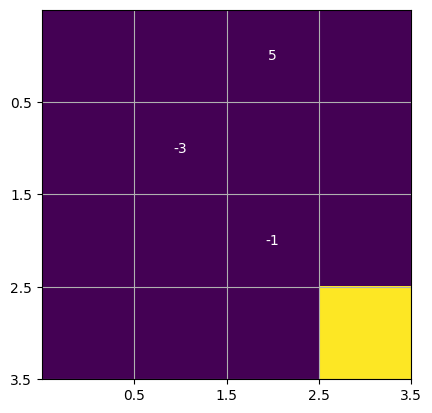

[[ 9.54906065  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61078174  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78995411  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.89999999  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09999289  2.98013711]
 [ 2.05855114  1.7746853   8.99999927  2.80265913]
 [ 0.         -0.1         9.99999996  0.        ]
 [ 0.          0.          0.          0.        ]]


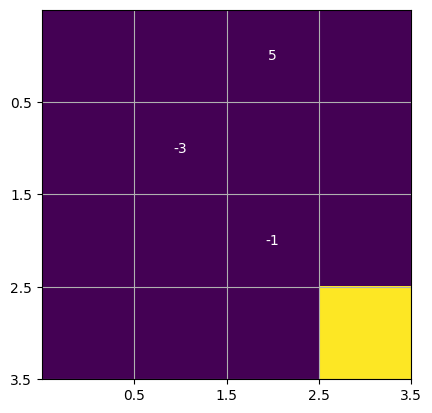

[[ 9.54912494  1.02552271  0.          0.35477989]
 [-0.29376886  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [10.61079944  0.19524425 -0.3         1.56566917]
 [ 0.1919712   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [11.78995806  1.14717698  0.21630908  0.62727892]
 [ 2.84071415  0.          0.          0.        ]
 [ 0.89999999  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 3.25464457  1.94532594 13.09999354  2.98013711]
 [ 2.05855114  1.7746853   8.99999934  2.80265913]
 [ 0.         -0.1         9.99999997  0.        ]
 [ 0.          0.          0.          0.        ]]


In [ ]:
env = GridEnvironment()
agent = QLearning(env)
gridStates = {(0,0):0,(0,1):1,(0,2):2,(0,3):3
                ,(1,0):4,(1,1):5,(1,2):6,(1,3):7
                ,(2,0):8,(2,1):9,(2,2):10,(2,3):11
                ,(3,0):12,(3,1):13,(3,2):14,(3,3):15}

episode_reward, epsilon_over_episodes = run_q_learning(env, agent, gridStates, num_episodes=1000)

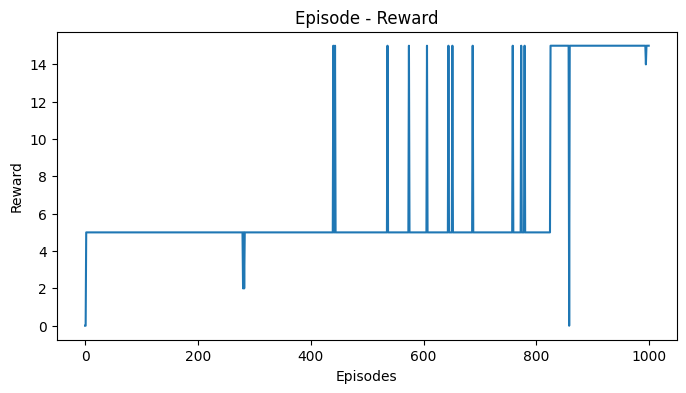

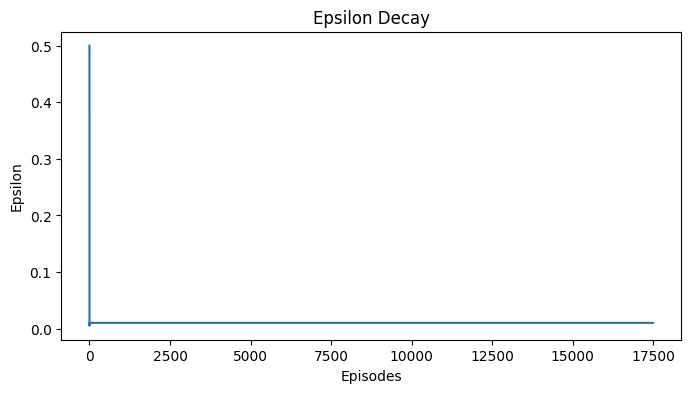

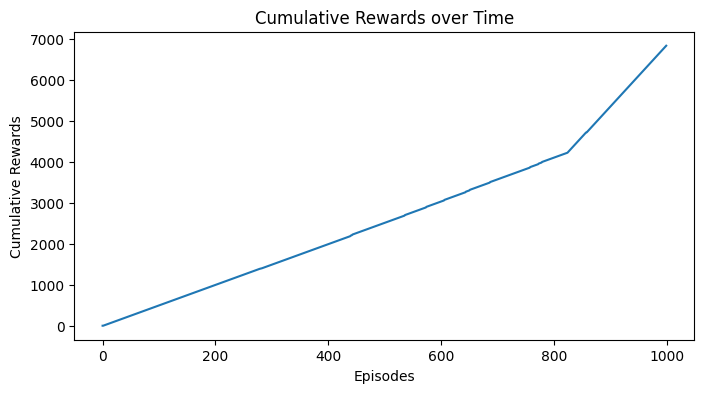

In [ ]:
plot_rewards_and_epsilon(episode_reward, epsilon_over_episodes)

# **Hyper Parameter Tuning**

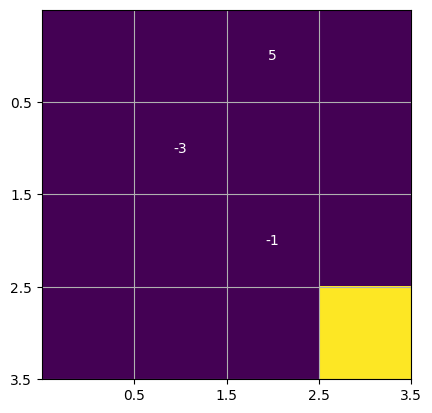

[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.  0. ]]


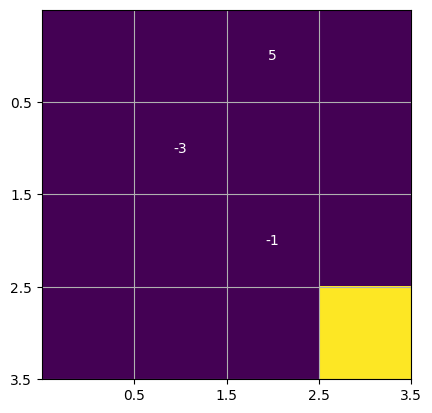

[[3.02193833 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [4.0409882  0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [5.18435041 0.         0.         0.258808  ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         6.39453772 0.        ]
 [0.         0.         0.097      6.26829583]
 [0.         0.         1.9        0.        ]
 [0.         0.         0.         0.        ]]


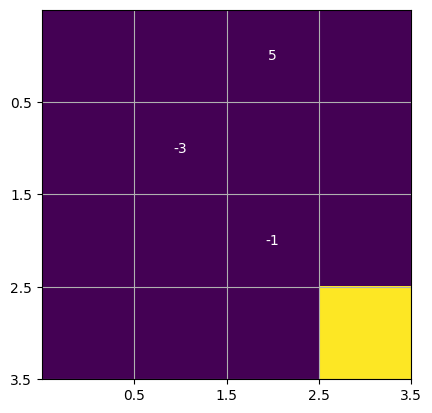

[[ 7.64860401  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.14091286  0.         -0.3         0.        ]
 [ 0.18605435  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.56085111  0.          0.          0.96772022]
 [ 3.08414696  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 1.58493102  1.41342448  9.04718624  1.50670229]
 [ 0.          0.17866763  0.2716      8.89634618]
 [ 0.          0.          2.71        0.        ]
 [ 0.          0.          0.          0.        ]]


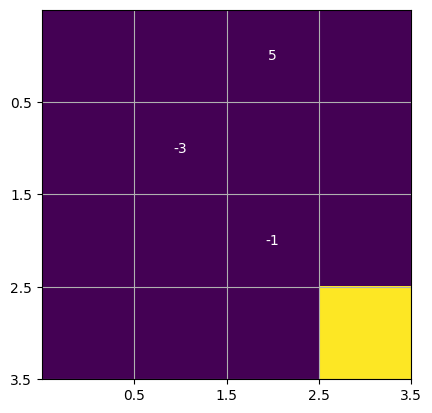

[[ 8.56730091  0.          0.          0.82981567]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.89773003  0.         -0.3         0.        ]
 [ 0.18605435  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.24644374  0.81066953  0.          1.74517022]
 [ 3.6499818   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.33839904  3.43578087  9.6266451   2.30168934]
 [ 0.91811696  0.45996312  0.50731     9.49831055]
 [ 0.          0.          3.439       0.        ]
 [ 0.          0.          0.          0.        ]]


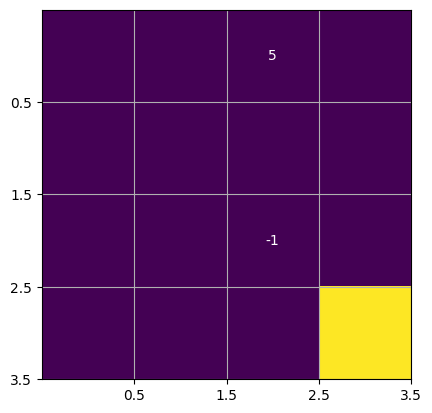

[[ 8.64486842  0.          0.          0.82981567]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 8.91656069  0.         -0.74617223  0.86377162]
 [ 0.96901269  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.2129637   0.81066953  0.          1.74517022]
 [ 6.05093419  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.33839904  3.43578087  9.48568136  3.00543063]
 [ 0.91811696  0.87055757  0.790162    9.41238037]
 [ 0.          0.          4.0951      0.        ]
 [ 0.          0.          0.          0.        ]]


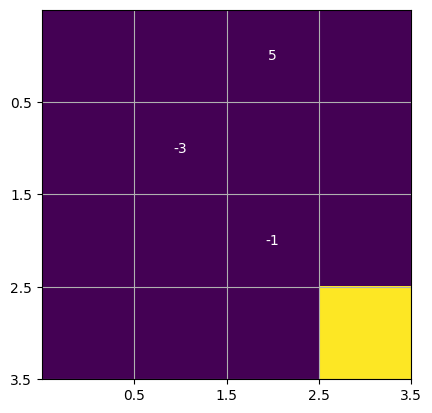

[[ 8.70869587  0.84428472  0.          0.82981567]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.02624074  0.         -0.74617223  0.86377162]
 [ 0.96901269  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.34553094  0.81066953  0.          2.47711218]
 [ 6.36509641  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.33839904  4.94066631  9.76562575  3.00543063]
 [ 1.73867153  1.37044243  1.1083705   9.57635663]
 [ 0.          0.          4.68559     0.        ]
 [ 0.          0.          0.          0.        ]]


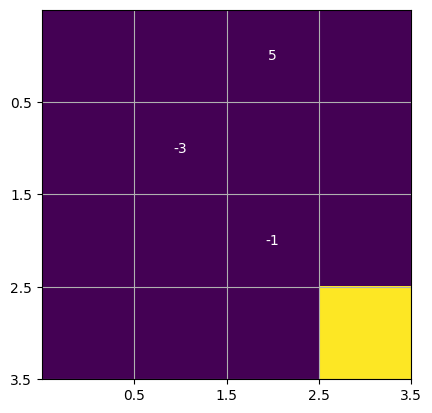

[[ 8.80421757  0.84428472  0.          0.82981567]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.10646031  0.         -0.74617223  0.86377162]
 [ 0.96901269  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 9.39498619  0.81066953  0.          2.47711218]
 [ 6.36509641  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.33839904  4.94066631  9.85377966  3.67549881]
 [ 2.49942393  1.37044243  1.45203568  9.62032767]
 [ 0.          0.          5.217031    0.        ]
 [ 0.          0.          0.          0.        ]]


In [ ]:
env = GridEnvironment()
agent = QLearning(env,gamma=0.97,decay_factor=0.93)
episode_reward, epsilon_over_episodes = run_q_learning(env, agent, gridStates, num_episodes=300)

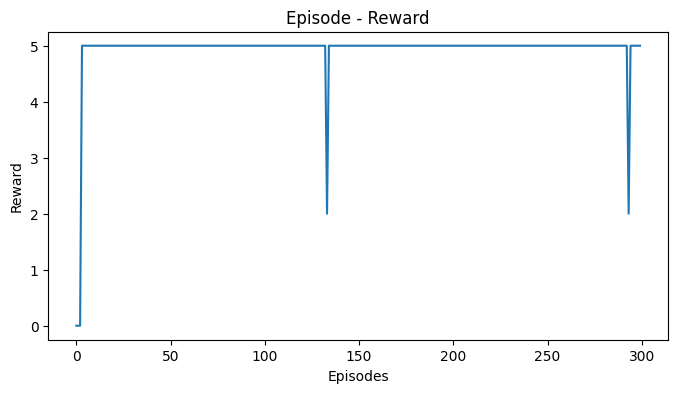

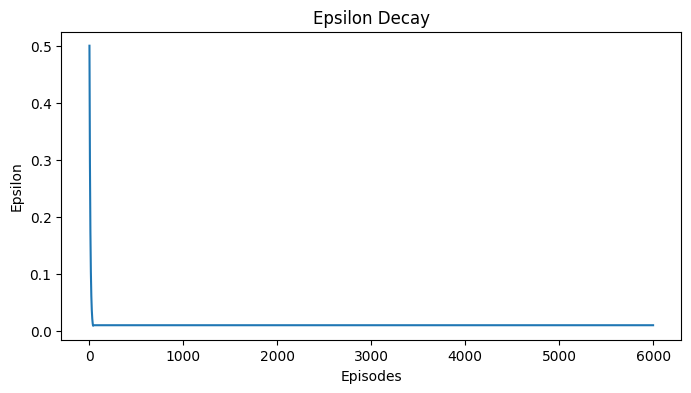

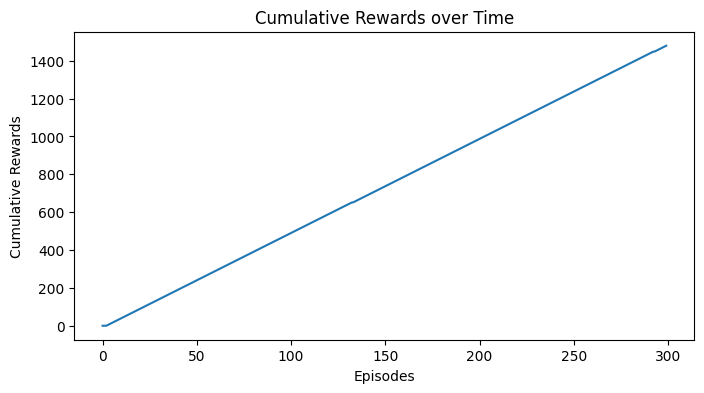

In [ ]:
plot_rewards_and_epsilon(episode_reward, epsilon_over_episodes)

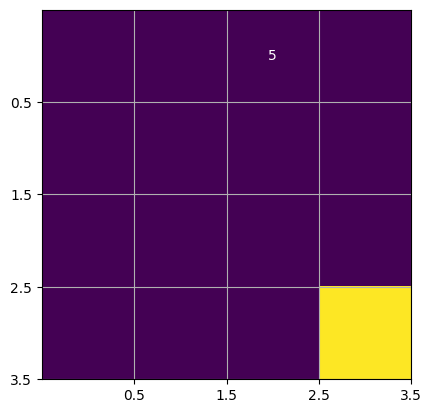

[[ 0.          0.          0.          0.        ]
 [-0.3         0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.0445706   0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.7720493  -0.3        -0.1         0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.25766364  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          0.        ]]


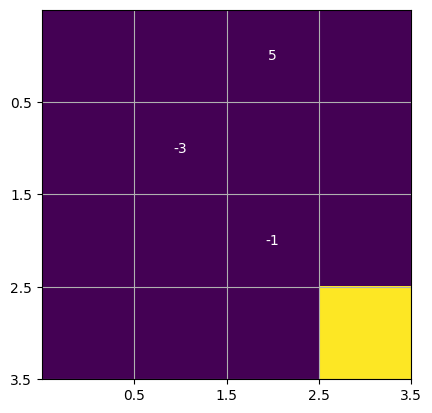

[[ 6.73461526e-01  0.00000000e+00  0.00000000e+00  6.10795137e-04]
 [-3.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.53230597e+00  5.46250374e-03  0.00000000e+00  0.00000000e+00]
 [ 5.59449826e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.03461055e-03  3.01031803e+00  7.53358019e-02]
 [ 4.62782825e+00 -7.93419951e-01 -1.00000000e-01  5.26746590e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.42347909e+00  9.80000000e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.90000000e+00  0.00000000e

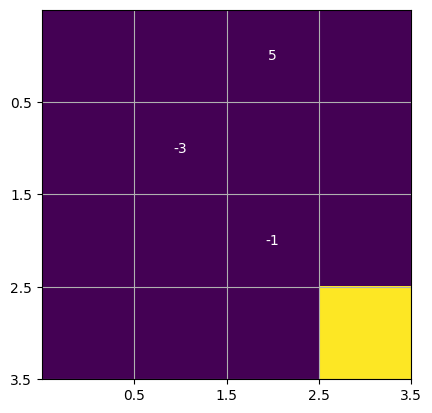

[[ 2.34894837e+00  0.00000000e+00  0.00000000e+00  6.10795137e-04]
 [-3.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.77786826e+00  5.46250374e-03  0.00000000e+00  0.00000000e+00]
 [ 5.59449826e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.03461055e-03  5.38829924e+00  7.53358019e-02]
 [ 7.23072353e+00 -7.93419951e-01 -1.00000000e-01  9.04084466e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.51301218e-01  6.65070629e+00  2.74400000e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.71000000e+00  0.00000000e

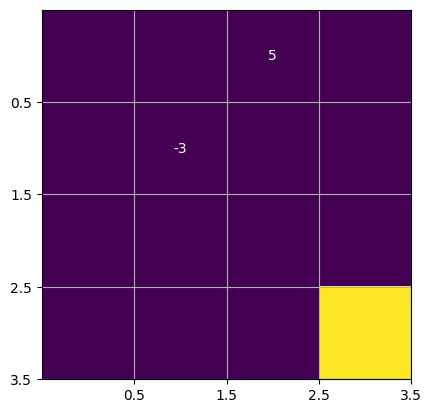

[[ 1.21499773e+01  0.00000000e+00  0.00000000e+00  1.11460652e+00]
 [-3.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.26514594e+01  5.46250374e-03  0.00000000e+00  0.00000000e+00]
 [ 5.59449826e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.03461055e-03  1.31259051e+01  7.53358019e-02]
 [ 1.40237906e+01 -7.93419951e-01 -1.90000000e-01  1.81064673e+00]
 [ 2.65580000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.41940869e+00  1.34942285e+01  2.74400000e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.43900000e+00  0.00000000e

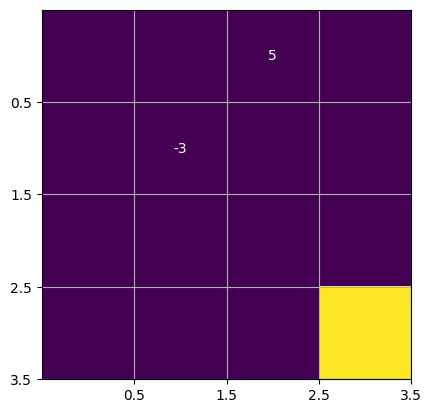

[[ 1.23733464e+01  0.00000000e+00  0.00000000e+00  1.11460652e+00]
 [-3.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.28830009e+01  5.46250374e-03  0.00000000e+00  0.00000000e+00]
 [ 5.59449826e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.03461055e-03  1.34027690e+01  7.53358019e-02]
 [ 1.40059040e+01 -7.93419951e-01 -2.44973160e-01  1.81064673e+00]
 [ 5.76044000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.41940869e+00  1.38099901e+01  2.74400000e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  4.09510000e+00  0.00000000e

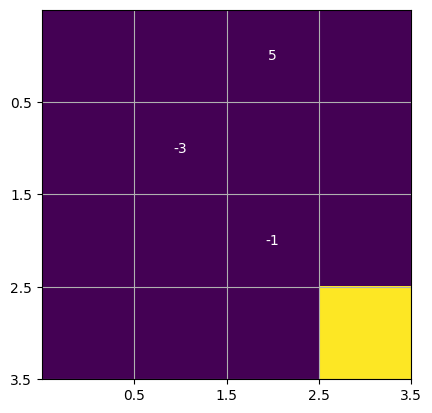

[[ 1.30283758e+01  1.24336602e+00  0.00000000e+00  1.11460652e+00]
 [-3.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.34577262e+01  5.46250374e-03 -2.45173917e-01  0.00000000e+00]
 [ 1.87773148e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.03461055e-03  1.38425897e+01  1.38913972e+00]
 [ 1.43168024e+01 -7.93419951e-01 -2.44973160e-01  2.96658873e+00]
 [ 5.76044000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.55710952e+00  1.41308266e+01  6.48279800e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  4.68559000e+00  0.00000000e

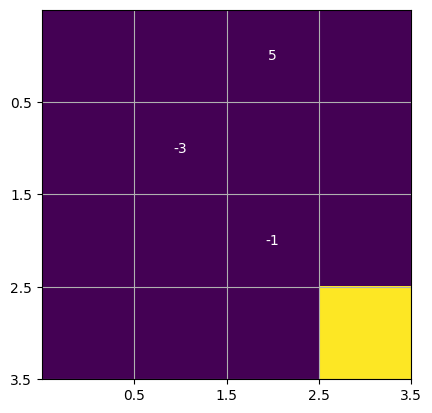

[[ 1.30896331e+01  1.24336602e+00  0.00000000e+00  1.11460652e+00]
 [-3.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.35033716e+01  5.46250374e-03 -2.45173917e-01  0.00000000e+00]
 [ 1.87773148e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.03461055e-03  1.38955867e+01  1.38913972e+00]
 [ 1.43148313e+01 -7.93419951e-01 -2.44973160e-01  2.96658873e+00]
 [ 5.76044000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.55710952e+00  1.41973926e+01  1.04263964e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  5.21703100e+00  0.00000000e

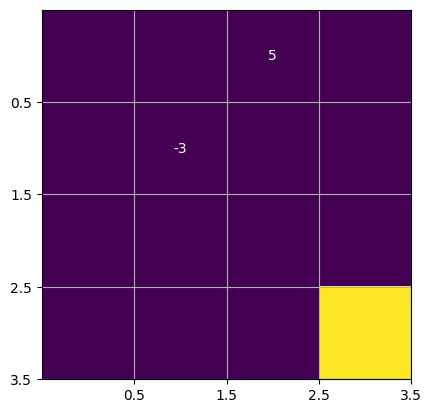

[[ 1.35249772e+01  1.24336602e+00  0.00000000e+00  1.11460652e+00]
 [-3.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.38521660e+01  5.46250374e-03 -2.45173917e-01  0.00000000e+00]
 [ 1.87773148e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.03461055e-03  1.41609868e+01  1.38913972e+00]
 [ 1.45347003e+01 -7.93419951e-01 -2.64023532e-01  4.03590475e+00]
 [ 1.02970864e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.59652056e+00  1.43726899e+01  1.04263964e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  5.69532790e+00  0.00000000e

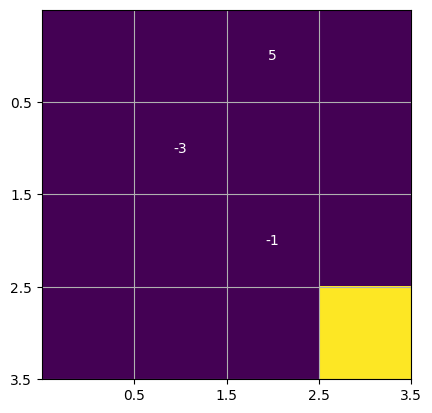

[[ 1.35995404e+01  1.24336602e+00  0.00000000e+00  1.11460652e+00]
 [-3.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.39309161e+01  1.33490189e+00 -2.45173917e-01  0.00000000e+00]
 [ 1.87773148e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.03461055e-03  1.43552106e+01  1.38913972e+00]
 [ 1.49442982e+01 -7.93419951e-01 -2.64023532e-01  4.03590475e+00]
 [ 1.02970864e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.59652056e+00  1.47585017e+01  1.49651781e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  6.12579511e+00  0.00000000e

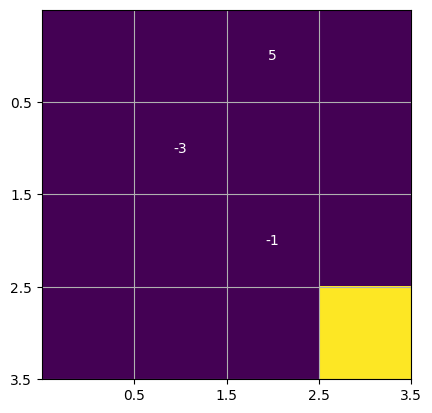

[[ 1.37977586e+01  1.24336602e+00  0.00000000e+00  1.11460652e+00]
 [-3.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.41671617e+01  1.33490189e+00 -2.45173917e-01  0.00000000e+00]
 [ 3.18178457e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.03461055e-03  1.45079464e+01  1.38913972e+00]
 [ 1.49190831e+01 -8.30060270e-01 -2.64023532e-01  5.05177075e+00]
 [ 1.02970864e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.59652056e+00  1.47341483e+01  1.94719395e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  6.51321560e+00  0.00000000e

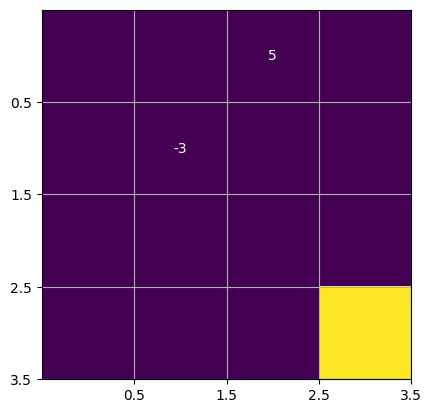

[[ 1.38774389e+01  1.24336602e+00  0.00000000e+00  1.11460652e+00]
 [-3.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.42184371e+01  1.33490189e+00 -2.45173917e-01  0.00000000e+00]
 [ 4.32602651e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.03461055e-03  1.45343848e+01  1.38913972e+00]
 [ 1.49954234e+01 -7.35239356e-01 -2.36709732e-01  5.05177075e+00]
 [ 1.56503290e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.59652056e+00  1.47572899e+01  1.94719395e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  6.86189404e+00  0.00000000e

In [ ]:
env = GridEnvironment()
agent = QLearning(env,gamma=0.98,decay_factor=0.98)
episode_reward, epsilon_over_episodes = run_q_learning(env, agent, gridStates, num_episodes=300)

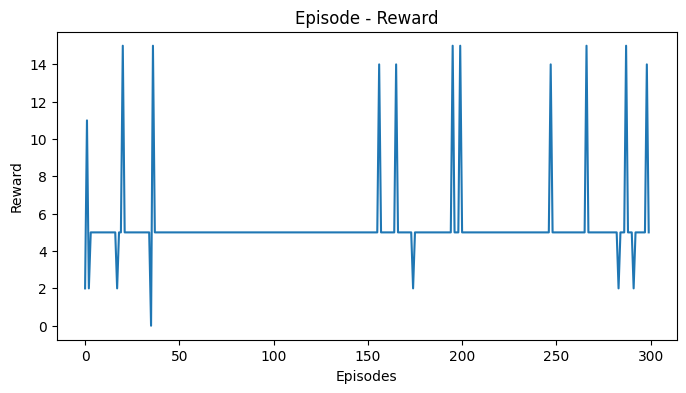

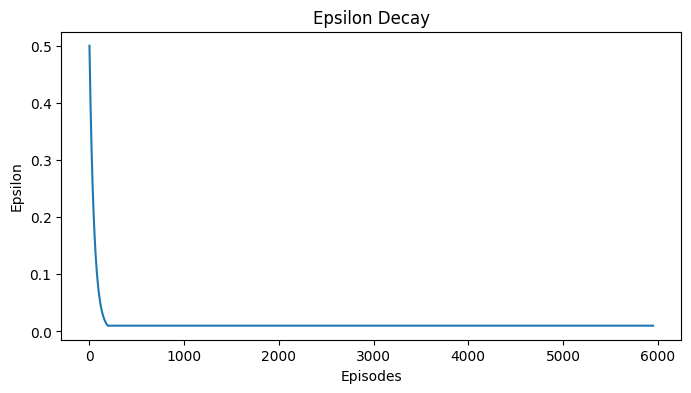

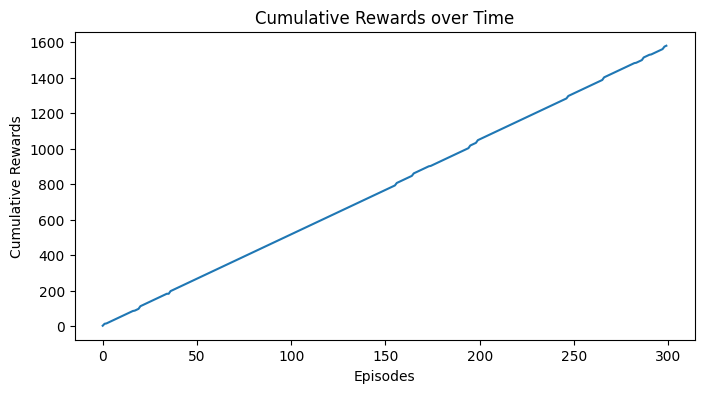

In [ ]:
plot_rewards_and_epsilon(episode_reward, epsilon_over_episodes)

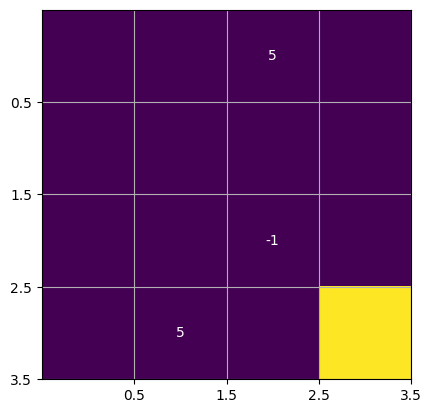

[[ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.  -0.3  0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 1.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]]


In [ ]:
env = GridEnvironment()
agent = QLearning(env,gamma=0.98,decay_factor=0.9)
episode_reward, epsilon_over_episodes = run_q_learning(env, agent, gridStates, num_episodes=300)

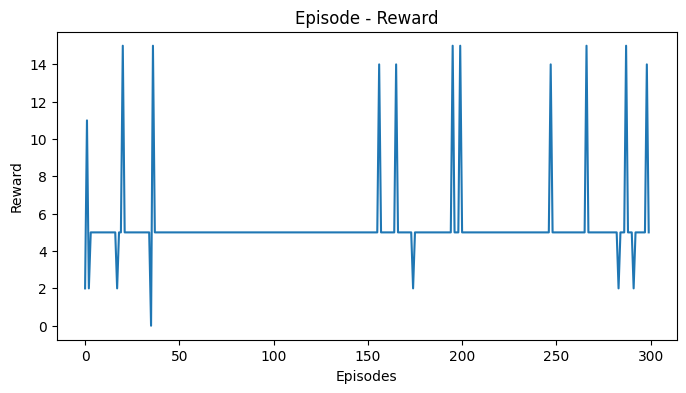

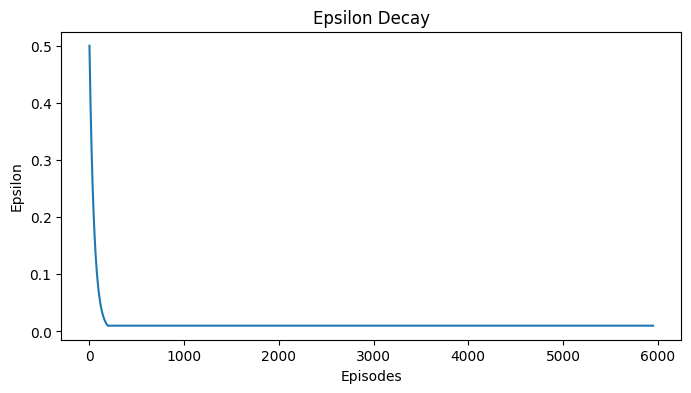

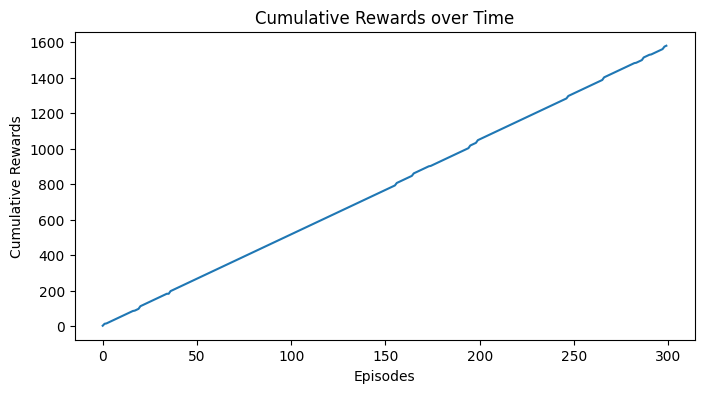

In [ ]:
plot_rewards_and_epsilon(episode_reward, epsilon_over_episodes)

# **Greedy Approach**

In [14]:
env = GridEnvironment()
agent = QLearning(env,epsilon=0)
gridStates = {(0,0):0,(0,1):1,(0,2):2,(0,3):3
                ,(1,0):4,(1,1):5,(1,2):6,(1,3):7
                ,(2,0):8,(2,1):9,(2,2):10,(2,3):11
                ,(3,0):12,(3,1):13,(3,2):14,(3,3):15}

episode_reward, epsilon_over_episodes = run_q_learning(env, agent, gridStates, num_episodes=10)

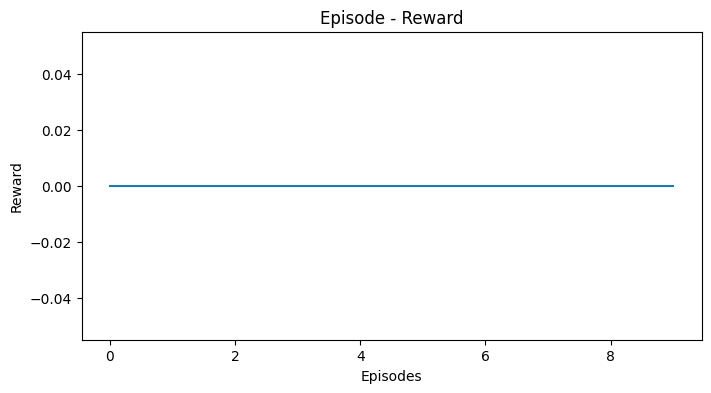

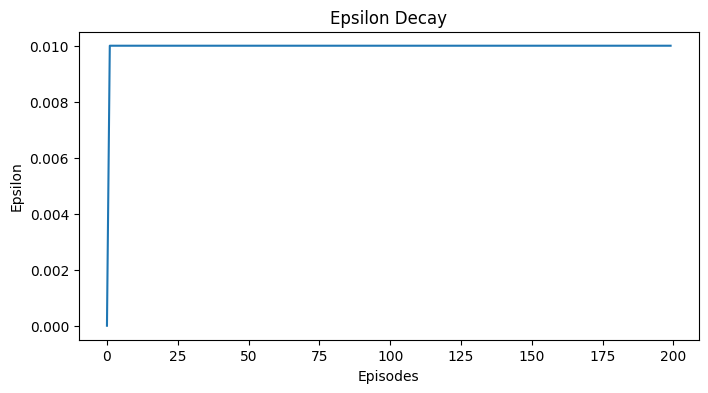

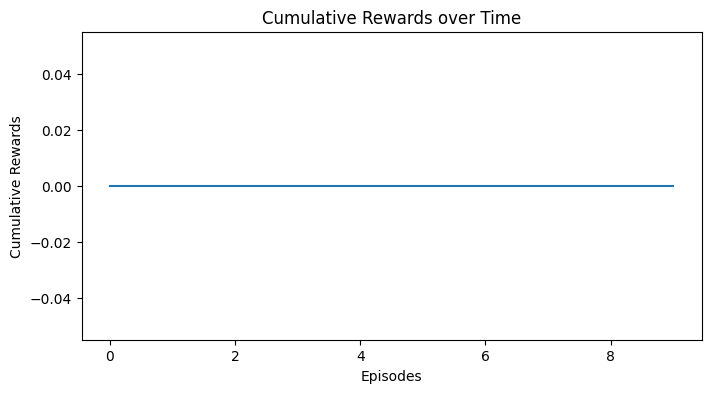

In [16]:
plot_rewards_and_epsilon(episode_reward, epsilon_over_episodes)